In [3]:
import logging
import os
from collections import OrderedDict
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file, get_checkpoint_url
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.data.datasets.coco import register_coco_instances

%matplotlib inline

# The challenge not addressed by the baseline

While we achieved what most would consider "good" performance in the baseline, there is something peculiar about the by-class performance. Some classes perform exceedingly well, but others (like the Supermarine) perform poorly in comparison. While a lot of this could be explained by poor data for a given class, which often requires either better annotations, more representative samples, or synthetic data to resolve. However, another obvious answer is the class distribution. Most real world problems are not class balanced (at least not the ones we actually care about). Datasets change and problems evolve at a rapid pace, introducing new categories to our target sets (known as an open-set problem). Given data is often scarce for new targets when they are first observed, this leads to a long-tailed class distribution (e.g. many samples for some classes, few samples for others). Without appropriate regularization techniques, classes in the tail of this distribution (few samples) often suffer in performance as the random sampling presents the head classes to the model more frequently. Lets see what the training dataset distribution looks like.

In [4]:
with open('/home/zack/datasets/manufacturer_identification/data/coco/train.json', 'r') as f:
    train_data = json.load(f)

category_id_to_name_map = {x['id']: x['name'] for x in train_data['categories']}
category_counts = {x : 0 for x in category_id_to_name_map.values()}
annotations_per_image_id = {x['id'] : 0 for x in train_data['images']}
for annotation in train_data['annotations']:
    cat_name = category_id_to_name_map[annotation['category_id']]
    category_counts[cat_name] += 1
    annotations_per_image_id[annotation['image_id']] += 1
    
category_counts = dict(sorted(category_counts.items(), key=lambda item: item[1]))
print(f'Most annotations in any given scene: {max(annotations_per_image_id.values())}')

Most annotations in any given scene: 1


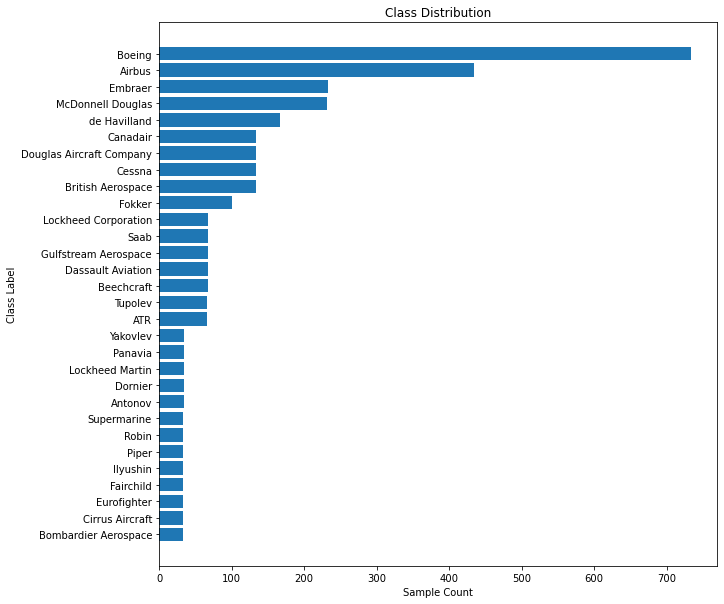

In [5]:
fig = plt.figure(figsize=(10, 10))
plt.barh(y=list(category_counts.keys()), width=category_counts.values())
plt.title('Class Distribution')
plt.ylabel('Class Label')
plt.xlabel('Sample Count')
plt.show()

Clearly, the class distibtruion follows a long-tailed distribution which will effect our trained model. One way to overcome this is class-balanced sampling, so lets try that. To do that, we can compute the inverse class weights by inverting the sample counts, which can become our new sampling weights. Rare classes will be weighted more heavily than common classes.


## LVIS Repeat Factor Sampler

Detectron2 provides a built-in `RepeatFactorTrainingSampler` that samples images base on the frequency of items in the dataset. However, this sampler contains added complexity to account for multiple objects in a single scene- something we conveniently don't have to deal with. So, instead of using the `RepeatFactorTrainingSampler` and having to worry about the stochastic rounding, lets write our own simpler `WeightedRandomSampler`. 

First, lets walk through how we will compute the weights of the categories.

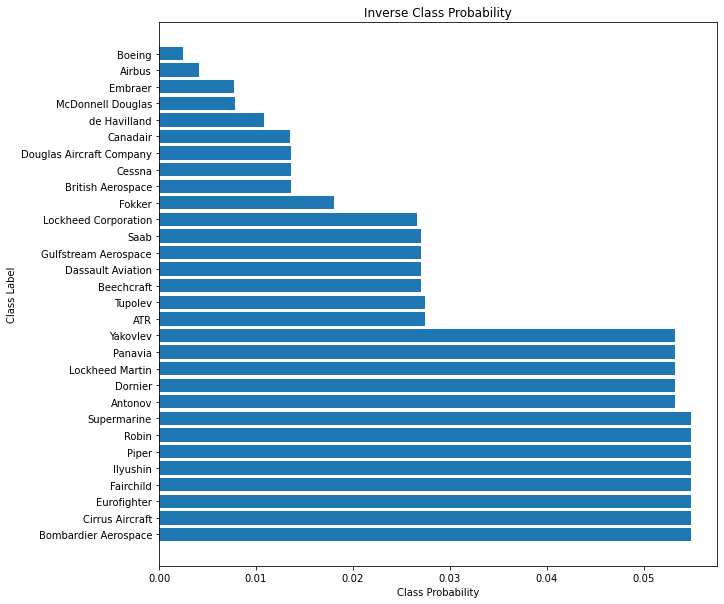

In [6]:
# Get a count for all of the categories
sample_counts = np.array(list(category_counts.values()))
# Compute the inverse frequency of all the categories (More frequent categories => Lower value)
inverse_sample_counts = 1 / sample_counts
# This is not necessary, but lets convert it into a probability distribution for visualization purposes
inverse_class_prob = inverse_sample_counts / inverse_sample_counts.sum()

fig = plt.figure(figsize=(10, 10))
plt.barh(y=list(category_counts.keys()), width=inverse_class_prob)
plt.title('Inverse Class Probability')
plt.ylabel('Class Label')
plt.xlabel('Class Probability')
plt.show()

# Custom WeightedRandomSampler

Now that we can invert the class probability distribution, lets implement it as a sampler to use during training. Let's implement a custom `WeightedRandomSampler` that computes the inverse class probabilities as shown above and scatters them to all of the samples in our training dataset. Then, each epoch, we can draw samples based on this "weighting", shuffle, then train on them.

Ultimately, we hope to overcome the class imbalance and train a better predictor on **most** categories at the potential sacrifice of performance on the head categories.

In [7]:
from detectron2.data.samplers import RepeatFactorTrainingSampler
from torch.utils.data.sampler import Sampler
from collections import defaultdict
import torch
from detectron2.utils import comm
import itertools


class WeightedRandomSampler(Sampler):
    """
    Similar to TrainingSampler, but a sample may appear more times than others based
    on its categorical probability in the dataset. Since we don't want to do too much surgery, we
    mimic the signature of RepeatFactorTrainingSampler, and will monkey patch this in.
    """

    def __init__(self, repeat_factors, *, shuffle=True, seed=None):
        """
        Args:
            repeat_factors (Tensor): a float vector, the repeat factor for each indice. When it's
                full of ones, it is equivalent to ``TrainingSampler(len(repeat_factors), ...)``.
            shuffle (bool): whether to shuffle the indices or not
            seed (int): the initial seed of the shuffle. Must be the same
                across all workers. If None, will use a random seed shared
                among workers (require synchronization among all workers).
        """
        self._shuffle = shuffle
        if seed is None:
            seed = comm.shared_random_seed()
        self._seed = int(seed)

        self._rank = comm.get_rank()
        self._world_size = comm.get_world_size()

        # Store the repeat factors for later use
        self.repeat_factors = repeat_factors


    @staticmethod
    def repeat_factors_from_category_frequency(dataset_dicts, repeat_thresh):
        """
        Compute the inverse category weights and scatter them across all samples in the dataset.

        Args:
            dataset_dicts (list[dict]): annotations in Detectron2 dataset format.
            repeat_thresh (float): This is not used

        Returns:
            torch.Tensor:
                the i-th element is the repeat factor for the dataset image at index i.
        """
        # 1. For each category c, compute the fraction of images that contain it: f(c)
        category_freq = defaultdict(int)
        for dataset_dict in dataset_dicts:  # For each image (without repeats)
            cat_ids = {ann["category_id"] for ann in dataset_dict["annotations"]}
            for cat_id in cat_ids:
                category_freq[cat_id] += 1
                
                
        inverse_category_freq = {k : 1 / v for k, v in category_freq.items()}
        total_inverse_category_freq = sum(inverse_category_freq.values())
        inverse_category_freq = {k : v / total_inverse_category_freq for k, v in inverse_category_freq.items()}
        print(f'Weighting draws by {inverse_category_freq}')
        # 3. For each image I, compute the image-level repeat factor:
        #    r(I) = max_{c in I} r(c)
        rep_factors = []
        for dataset_dict in dataset_dicts:
            cat_ids = {ann["category_id"] for ann in dataset_dict["annotations"]}
            rep_factor = max({inverse_category_freq[cat_id] for cat_id in cat_ids})
            rep_factors.append(rep_factor)

        return torch.tensor(rep_factors, dtype=torch.float32)


    def _get_epoch_indices(self, generator):
        """
        Create a list of dataset indices (with repeats) to use for one epoch.

        Args:
            generator (torch.Generator): pseudo random number generator used for
                stochastic rounding.

        Returns:
            torch.Tensor: list of dataset indices to use in one epoch. Each index
                is repeated based on its calculated repeat factor.
        """
        # Since repeat factors are fractional, we use stochastic rounding so
        # that the target repeat factor is achieved in expectation over the
        # course of training

            
        indices = torch.multinomial(self.repeat_factors, 
                                    len(self.repeat_factors), 
                                    True, 
                                    generator=None)
        return indices.long()

    def __iter__(self):
        start = self._rank
        yield from itertools.islice(self._infinite_indices(), start, None, self._world_size)

    def _infinite_indices(self):
        g = torch.Generator()
        g.manual_seed(self._seed)
        while True:
            # Sample indices with repeats determined by stochastic rounding; each
            # "epoch" may have a slightly different size due to the rounding.
            indices = self._get_epoch_indices(g)
            if self._shuffle:
                randperm = torch.randperm(len(indices), generator=g)
                yield from indices[randperm].tolist()
            else:
                yield from indices.tolist()

# Expose our Sampler to Detectron2

Implementing the sampler was the easy part, now we need to expose it to the Detectron2 API so it can instantiate it at runtime. To do this, we simply need to overwrite some methods built-in to detectron2.

In [8]:
from detectron2.data.catalog import DatasetCatalog, MetadataCatalog
from detectron2.data.common import AspectRatioGroupedDataset, DatasetFromList, MapDataset, ToIterableDataset
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data.build import get_detection_dataset_dicts, build_batch_data_loader
from detectron2.config import configurable
from detectron2.utils.logger import _log_api_usage
import torch.utils.data as torchdata
import logging

def _train_loader_from_config(cfg, mapper=None, *, dataset=None, sampler=None):
    if dataset is None:
        dataset = get_detection_dataset_dicts(
            cfg.DATASETS.TRAIN,
            filter_empty=cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS,
            min_keypoints=cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE
            if cfg.MODEL.KEYPOINT_ON
            else 0,
            proposal_files=cfg.DATASETS.PROPOSAL_FILES_TRAIN if cfg.MODEL.LOAD_PROPOSALS else None,
        )
        _log_api_usage("dataset." + cfg.DATASETS.TRAIN[0])

    if mapper is None:
        mapper = DatasetMapper(cfg, True)

    if sampler is None:
        sampler_name = cfg.DATALOADER.SAMPLER_TRAIN
        logger = logging.getLogger(__name__)
        print("Using training sampler {}".format(sampler_name))
        logger.info("Using training sampler {}".format(sampler_name))
        if sampler_name == "TrainingSampler":
            sampler = TrainingSampler(len(dataset))
        elif sampler_name == "RepeatFactorTrainingSampler":
            repeat_factors = RepeatFactorTrainingSampler.repeat_factors_from_category_frequency(
                dataset, cfg.DATALOADER.REPEAT_THRESHOLD
            )
            sampler = RepeatFactorTrainingSampler(repeat_factors)
        elif sampler_name == "RandomSubsetTrainingSampler":
            sampler = RandomSubsetTrainingSampler(len(dataset), cfg.DATALOADER.RANDOM_SUBSET_RATIO)
        elif sampler_name == "WeightedRandomSampler":
            repeat_factors = WeightedRandomSampler.repeat_factors_from_category_frequency(
                dataset, cfg.DATALOADER.REPEAT_THRESHOLD
            )
            sampler = WeightedRandomSampler(repeat_factors)
        else:
            raise ValueError("Unknown training sampler: {}".format(sampler_name))

    return {
        "dataset": dataset,
        "sampler": sampler,
        "mapper": mapper,
        "total_batch_size": cfg.SOLVER.IMS_PER_BATCH,
        "aspect_ratio_grouping": cfg.DATALOADER.ASPECT_RATIO_GROUPING,
        "num_workers": cfg.DATALOADER.NUM_WORKERS,
    }

@configurable(from_config=_train_loader_from_config)
def build_our_custom_detection_train_loader(
    dataset,
    *,
    mapper,
    sampler=None,
    total_batch_size,
    aspect_ratio_grouping=True,
    num_workers=0,
    collate_fn=None,
):
    """
    Build a dataloader for object detection with some default features.
    Args:
        dataset (list or torch.utils.data.Dataset): a list of dataset dicts,
            or a pytorch dataset (either map-style or iterable). It can be obtained
            by using :func:`DatasetCatalog.get` or :func:`get_detection_dataset_dicts`.
        mapper (callable): a callable which takes a sample (dict) from dataset and
            returns the format to be consumed by the model.
            When using cfg, the default choice is ``DatasetMapper(cfg, is_train=True)``.
        sampler (torch.utils.data.sampler.Sampler or None): a sampler that produces
            indices to be applied on ``dataset``.
            If ``dataset`` is map-style, the default sampler is a :class:`TrainingSampler`,
            which coordinates an infinite random shuffle sequence across all workers.
            Sampler must be None if ``dataset`` is iterable.
        total_batch_size (int): total batch size across all workers.
        aspect_ratio_grouping (bool): whether to group images with similar
            aspect ratio for efficiency. When enabled, it requires each
            element in dataset be a dict with keys "width" and "height".
        num_workers (int): number of parallel data loading workers
        collate_fn: a function that determines how to do batching, same as the argument of
            `torch.utils.data.DataLoader`. Defaults to do no collation and return a list of
            data. No collation is OK for small batch size and simple data structures.
            If your batch size is large and each sample contains too many small tensors,
            it's more efficient to collate them in data loader.
    Returns:
        torch.utils.data.DataLoader:
            a dataloader. Each output from it is a ``list[mapped_element]`` of length
            ``total_batch_size / num_workers``, where ``mapped_element`` is produced
            by the ``mapper``.
    """
    if isinstance(dataset, list):
        dataset = DatasetFromList(dataset, copy=False)
    if mapper is not None:
        dataset = MapDataset(dataset, mapper)

    if isinstance(dataset, torchdata.IterableDataset):
        assert sampler is None, "sampler must be None if dataset is IterableDataset"
    else:
        if sampler is None:
            sampler = TrainingSampler(len(dataset))
        assert isinstance(sampler, torchdata.Sampler), f"Expect a Sampler but got {type(sampler)}"
    return build_batch_data_loader(
        dataset,
        sampler,
        total_batch_size,
        aspect_ratio_grouping=aspect_ratio_grouping,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

Under the hood, Detectron2 doesn't do exactly this, but a rough approximation of it.

In [9]:
from detectron2.data import build_detection_train_loader


class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains pre-defined default logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can write your
    own training loop. You can use "tools/plain_train_net.py" as an example.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return [COCOEvaluator(dataset_name, output_dir=output_folder)]
    
    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA
        # Only support some R-CNN models.
        logger.info("Running inference with test-time augmentation ...")
        model = GeneralizedRCNNWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res
    
    @classmethod
    @configurable(from_config=_train_loader_from_config)
    def build_train_loader(cls, cfg):
        """
        Returns:
            iterable
        It now calls :func:`detectron2.data.build_detection_train_loader`.
        Overwrite it if you'd like a different data loader.
        """
        return build_our_custom_detection_train_loader(cfg)

# Construct the configuration

Detectron2 provides a flat-file interface, so that's what we'll be setting up in the below cells.

In [10]:
cfg = get_cfg()

# Initial model selection

A good baseline will be utilizing a Faster-RCNN with an FPN. The Faster RCNN is a two-stage object detector that has set many benchmarks over the years and still provides robust performance in the era of enhanced single-stage detectors. The FPN provides multi-scale feature maps to enhance scale invariance of the resulting detector, which is less of a concern with this dataset since all of the data is hand held imagery and the objects are fairly uniform in scale (unlike in overhead imagery). We'll use a Resnet50 as the backbone because it provides decent feature extraction performance without being computationally or memory intensive. Lets load the configuration for the R50 Faster-RCNN FPN now.

In [11]:
cfg.merge_from_file(get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'))

# Setup our data configuration

Below, we are simply defining the names of the datasets we wish to use. These datasets have not been registered yet, but we will do that in the cell after. I'm going to use 8 workers because I have a CPU with 12 cores and want to ensure I have enough processes loading data to saturate the PCIE/GPU without overtaxing my system and causing stuttering.

In [12]:
cfg.DATASETS.TRAIN = ('manu_id_train',)
cfg.DATASETS.TEST = ('manu_id_val',)
cfg.DATALOADER.NUM_WORKERS = 8

# Invoke our WeightedRandomSampler

To ensure Detectron2 uses our new sampler, we simpley define it in the config. Lets do that now.

In [13]:
cfg.DATALOADER.SAMPLER_TRAIN = 'WeightedRandomSampler'

## Register the dataset

The cell below is where the dataset is registered by name (matching the names we defined above). To do this, we simply register the directory containing the imagery and the COCO json files we created previously. Since we are training, we want to register the train and validation sets. The validation set will allow us to evaluate our model at intermediate phases throughout training and perform model selection. Since we are using the val set to select our best model, it should **not** be the same dataset we ultimately evaluate our model on (that will be the test set).

In [14]:
image_root = '/home/zack/datasets/manufacturer_identification/data/images'
register_coco_instances('manu_id_train', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/train.json')
register_coco_instances('manu_id_val', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/val.json')

# Define the model weights we wish to use for initialization

Initialization of object detectors is a massively explored sub-field of machine learning. In some cases, random initialization is okay to use, but utilizing pre-trained feature extractors (e.g. Resnet50) or full pre-trained networks (e.g. Faster-RCNN FPN) regularly provides superior performance to random initialization. There are several various pretraining regimes, of which the most populare are taking 1. Imagenet pretrained feature extractors (recognition task), 2. COCO/other detection dataset pretrained detectors (detection task), or 3. Self-supervised pretrained feature extractors (recognition task). Generally, the recognition pretrained feature extractors provide robust feature extraction capabilities and a strong starting point for optimization to take over. However, one challenge is that the remainder of the network (FPN Llteral connections, RPN, Box/Mask/Classifier heads) is still randomly initialized. Additionally, pre-training on recognition tasks often doesn't require scale information to the same level as an object detector, meaning some features may be useless/uninformative.

Using a full pretrained network is in most ways superior to a simple pretrained feature extractor. Recent work has focused on unsupervised object detection training using Selective Search or properties of DETR, but these are still early techniques. For our application and for the sake of time/complexity, I will load the weights for a R50 Faster-RCNN FPN that was pretrained on the COCO dataset with Large Scale Jitter, which is a new augmentation and learning schedule that has shown large performance benefits.

In [15]:
# Large scale jitter likely won't help us here since most objects are at the same scale, but lets load the R50-FasterRCNN-FPN LSJ model weights as a good pretrained starting point.
cfg.MODEL.WEIGHTS = get_checkpoint_url('new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py')

# Set the number of classes

The problem description says there are 41 classes, but I only see 30 classes in the labels.txt file and in the unique values of the box_labels.txt file

In [16]:
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 30

# Define our training schedule

Since this dataset isn't very large, we likely don't need to train for very long. I'm also pressed on time, so shorter training runs are better. 40,000 iterations seems like a reasonable place to start, but even that is likely too many iterations to train and will likely lead to overfitting. As mentioned above, one way to avoid overfitting is through utilizing a validation dataset. Detectron2 performs intermediate validation, but doesn't checkpoint based on the metric (unfortunately). After training, it will be up to us to determine the best model based on the logged metrics. Lets set the batch size to 6 (RTX 3090), and lets step the learning rate down at a schedule of 25000 and 35000 iterations. This will reduce the learning rate by some gamma (0.1) at these iterations, ideally model improving convergence as we approach a minima (hopefully the global minima and not a pesky local minima. CosineScheduler/Cyclic learning rates could help us get around that, but Detectron2 doesn't support those currently).

In [17]:
cfg.SOLVER.MAX_ITER = 40000
cfg.SOLVER.STEPS = (25000, 35000)
# I have to reduce the batch size here due to GPU memory constraints while I work on other things. This model will effectively see less data, but I think that's okay.
cfg.SOLVER.IMS_PER_BATCH = 6
# Checkpoint at a 1:1 ratio with evaluation
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.TEST.EVAL_PERIOD = 1000

cfg.OUTPUT_DIR = './output_class_balanced'

# Train the model

Train the model, making sure to load the weights we specified above.

In [16]:
"""
If you'd like to do anything fancier than the standard training logic,
consider writing your own training loop (see plain_train_net.py) or
subclassing the trainer.
"""
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
if cfg.TEST.AUG.ENABLED:
    trainer.register_hooks(
        [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]
    )

trainer.train()

[04/21 23:41:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [04/21 23:41:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 23:41:28 d2.data.datasets.coco]: Loaded 3334 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/train.json
[04/21 23:41:28 d2.data.build]: Removed 0 images with no usable annotations. 3334 images left.
[04/21 23:41:28 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|      ATR      | 66           |    Airbus     | 434          |    Antonov    | 34           |
|  Beechcraft   | 67           |    Boeing     | 733          | Bombardier .. | 33           |
| British Aer.. | 133          |   Canadair    | 134          |    Cessna     | 133          |
| Cirrus Airc.. | 33           | Dassault Av.. | 67          

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (31, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (31,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (120, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (120,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.bias
backbone.fpn_lateral3.bias
backbone.fpn_lateral4.bias
backb

[04/21 23:41:29 d2.engine.train_loop]: Starting training from iteration 0


/home/zack/anaconda3/envs/riverside/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/zack/anaconda3/envs/riverside/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/21 23:41:37 d2.utils.events]:  eta: 4:11:28  iter: 19  total_loss: 0.2932  loss_cls: 0.1164  loss_box_reg: 0.009293  loss_rpn_cls: 0.09114  loss_rpn_loc: 0.0523  time: 0.3779  data_time: 0.0262  lr: 0.00039962  max_mem: 5885M
[04/21 23:41:46 d2.utils.events]:  eta: 4:26:19  iter: 39  total_loss: 0.2718  loss_cls: 0.1389  loss_box_reg: 0.08177  loss_rpn_cls: 0.01241  loss_rpn_loc: 0.01527  time: 0.4034  data_time: 0.0060  lr: 0.00079922  max_mem: 5885M
[04/21 23:41:54 d2.utils.events]:  eta: 4:37:39  iter: 59  total_loss: 0.2232  loss_cls: 0.1148  loss_box_reg: 0.08254  loss_rpn_cls: 0.008943  loss_rpn_loc: 0.01049  time: 0.4116  data_time: 0.0060  lr: 0.0011988  max_mem: 6157M
[04/21 23:42:03 d2.utils.events]:  eta: 4:38:07  iter: 79  total_loss: 0.2075  loss_cls: 0.1072  loss_box_reg: 0.08508  loss_rpn_cls: 0.005604  loss_rpn_loc: 0.009233  time: 0.4144  data_time: 0.0061  lr: 0.0015984  max_mem: 6157M
[04/21 23:42:11 d2.utils.events]:  eta: 4:38:22  iter: 99  total_loss: 0.2186  

[04/21 23:46:41 d2.utils.events]:  eta: 4:40:51  iter: 719  total_loss: 0.1987  loss_cls: 0.1396  loss_box_reg: 0.04933  loss_rpn_cls: 0.002101  loss_rpn_loc: 0.007917  time: 0.4321  data_time: 0.0062  lr: 0.014386  max_mem: 6293M
[04/21 23:46:49 d2.utils.events]:  eta: 4:40:25  iter: 739  total_loss: 0.1833  loss_cls: 0.1276  loss_box_reg: 0.04308  loss_rpn_cls: 0.001112  loss_rpn_loc: 0.006278  time: 0.4312  data_time: 0.0060  lr: 0.014785  max_mem: 6293M
[04/21 23:46:57 d2.utils.events]:  eta: 4:39:50  iter: 759  total_loss: 0.1684  loss_cls: 0.1171  loss_box_reg: 0.04106  loss_rpn_cls: 0.001439  loss_rpn_loc: 0.006578  time: 0.4303  data_time: 0.0061  lr: 0.015185  max_mem: 6293M
[04/21 23:47:05 d2.utils.events]:  eta: 4:39:41  iter: 779  total_loss: 0.1766  loss_cls: 0.1214  loss_box_reg: 0.04123  loss_rpn_cls: 0.001043  loss_rpn_loc: 0.007177  time: 0.4300  data_time: 0.0061  lr: 0.015584  max_mem: 6293M
[04/21 23:47:14 d2.utils.events]:  eta: 4:39:04  iter: 799  total_loss: 0.18

[04/21 23:49:57 d2.evaluation.evaluator]: Inference done 2206/3333. Dataloading: 0.0008 s/iter. Inference: 0.0333 s/iter. Eval: 0.0001 s/iter. Total: 0.0343 s/iter. ETA=0:00:38
[04/21 23:50:02 d2.evaluation.evaluator]: Inference done 2358/3333. Dataloading: 0.0008 s/iter. Inference: 0.0333 s/iter. Eval: 0.0001 s/iter. Total: 0.0342 s/iter. ETA=0:00:33
[04/21 23:50:07 d2.evaluation.evaluator]: Inference done 2503/3333. Dataloading: 0.0008 s/iter. Inference: 0.0332 s/iter. Eval: 0.0001 s/iter. Total: 0.0342 s/iter. ETA=0:00:28
[04/21 23:50:12 d2.evaluation.evaluator]: Inference done 2640/3333. Dataloading: 0.0008 s/iter. Inference: 0.0334 s/iter. Eval: 0.0001 s/iter. Total: 0.0344 s/iter. ETA=0:00:23
[04/21 23:50:17 d2.evaluation.evaluator]: Inference done 2786/3333. Dataloading: 0.0008 s/iter. Inference: 0.0334 s/iter. Eval: 0.0001 s/iter. Total: 0.0344 s/iter. ETA=0:00:18
[04/21 23:50:22 d2.evaluation.evaluator]: Inference done 2934/3333. Dataloading: 0.0008 s/iter. Inference: 0.0334 s

[04/21 23:52:24 d2.utils.events]:  eta: 4:37:38  iter: 1239  total_loss: 0.1191  loss_cls: 0.08362  loss_box_reg: 0.02577  loss_rpn_cls: 0.0008107  loss_rpn_loc: 0.006172  time: 0.4319  data_time: 0.0069  lr: 0.02  max_mem: 6293M
[04/21 23:52:33 d2.utils.events]:  eta: 4:37:31  iter: 1259  total_loss: 0.1302  loss_cls: 0.08886  loss_box_reg: 0.03367  loss_rpn_cls: 0.001026  loss_rpn_loc: 0.007664  time: 0.4319  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/21 23:52:42 d2.utils.events]:  eta: 4:37:19  iter: 1279  total_loss: 0.1532  loss_cls: 0.1048  loss_box_reg: 0.0399  loss_rpn_cls: 0.001559  loss_rpn_loc: 0.006812  time: 0.4322  data_time: 0.0070  lr: 0.02  max_mem: 6293M
[04/21 23:52:51 d2.utils.events]:  eta: 4:37:12  iter: 1299  total_loss: 0.1325  loss_cls: 0.09292  loss_box_reg: 0.03188  loss_rpn_cls: 0.0008813  loss_rpn_loc: 0.006295  time: 0.4324  data_time: 0.0073  lr: 0.02  max_mem: 6293M
[04/21 23:53:00 d2.utils.events]:  eta: 4:37:03  iter: 1319  total_loss: 0.1311  los

[04/21 23:57:34 d2.utils.events]:  eta: 4:38:04  iter: 1939  total_loss: 0.08775  loss_cls: 0.05513  loss_box_reg: 0.02703  loss_rpn_cls: 0.0005604  loss_rpn_loc: 0.005444  time: 0.4346  data_time: 0.0065  lr: 0.02  max_mem: 6293M
[04/21 23:57:42 d2.utils.events]:  eta: 4:38:06  iter: 1959  total_loss: 0.1017  loss_cls: 0.06009  loss_box_reg: 0.03061  loss_rpn_cls: 0.0004905  loss_rpn_loc: 0.006911  time: 0.4346  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/21 23:57:52 d2.utils.events]:  eta: 4:37:49  iter: 1979  total_loss: 0.09166  loss_cls: 0.05517  loss_box_reg: 0.02744  loss_rpn_cls: 0.001497  loss_rpn_loc: 0.008883  time: 0.4346  data_time: 0.0074  lr: 0.02  max_mem: 6293M
WARNING [04/21 23:58:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 23:58:02 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 23:58:02 d2.data.d

[04/21 23:59:58 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 23:59:58 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 23:59:58 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 23:59:58 d2.evaluation.testing]: copypaste: 44.5509,56.7519,54.5036,nan,0.0000,44.5553
[04/21 23:59:58 d2.utils.events]:  eta: 4:37:31  iter: 1999  total_loss: 0.0934  loss_cls: 0.05469  loss_box_reg: 0.0301  loss_rpn_cls: 0.0007762  loss_rpn_loc: 0.006234  time: 0.4346  data_time: 0.0073  lr: 0.02  max_mem: 6293M
[04/22 00:00:06 d2.utils.events]:  eta: 4:37:11  iter: 2019  total_loss: 0.09154  loss_cls: 0.05538  loss_box_reg: 0.02866  loss_rpn_cls: 0.0005805  loss_rpn_loc: 0.006182  time: 0.4344  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 00:00:15 d2.utils.events]:  eta: 4:36:54  iter: 2039  total_loss: 0.08754  loss_cls: 0.05652  loss_box_reg: 0.02482  loss_rpn_cls: 0.0005258  loss_rpn_loc: 0.005976  time: 0.4343  data_time: 0.0074  lr: 0.02  max_m

[04/22 00:04:46 d2.utils.events]:  eta: 4:29:58  iter: 2659  total_loss: 0.0726  loss_cls: 0.03936  loss_box_reg: 0.03152  loss_rpn_cls: 0.0005355  loss_rpn_loc: 0.006098  time: 0.4344  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:04:55 d2.utils.events]:  eta: 4:30:11  iter: 2679  total_loss: 0.07492  loss_cls: 0.04262  loss_box_reg: 0.02656  loss_rpn_cls: 0.0001917  loss_rpn_loc: 0.00603  time: 0.4346  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:05:04 d2.utils.events]:  eta: 4:29:38  iter: 2699  total_loss: 0.07113  loss_cls: 0.03649  loss_box_reg: 0.02711  loss_rpn_cls: 0.0002083  loss_rpn_loc: 0.00516  time: 0.4347  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:05:12 d2.utils.events]:  eta: 4:29:13  iter: 2719  total_loss: 0.07523  loss_cls: 0.03771  loss_box_reg: 0.02796  loss_rpn_cls: 0.0005268  loss_rpn_loc: 0.006775  time: 0.4346  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:05:21 d2.utils.events]:  eta: 4:28:48  iter: 2739  total_loss: 0.0708

[04/22 00:08:49 d2.evaluation.evaluator]: Inference done 2934/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:13
[04/22 00:08:54 d2.evaluation.evaluator]: Inference done 3084/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0327 s/iter. ETA=0:00:08
[04/22 00:08:59 d2.evaluation.evaluator]: Inference done 3239/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:03
[04/22 00:09:02 d2.evaluation.evaluator]: Total inference time: 0:01:48.998620 (0.032752 s / iter per device, on 1 devices)
[04/22 00:09:02 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:45 (0.031797 s / iter per device, on 1 devices)
[04/22 00:09:02 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 00:09:02 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 00:11:13 d2.utils.events]:  eta: 4:22:04  iter: 3299  total_loss: 0.08774  loss_cls: 0.04264  loss_box_reg: 0.03673  loss_rpn_cls: 0.0003483  loss_rpn_loc: 0.005478  time: 0.4335  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:11:21 d2.utils.events]:  eta: 4:21:51  iter: 3319  total_loss: 0.08143  loss_cls: 0.03986  loss_box_reg: 0.03386  loss_rpn_cls: 0.0004121  loss_rpn_loc: 0.006002  time: 0.4334  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:11:30 d2.utils.events]:  eta: 4:21:34  iter: 3339  total_loss: 0.07378  loss_cls: 0.03576  loss_box_reg: 0.02949  loss_rpn_cls: 0.000354  loss_rpn_loc: 0.005849  time: 0.4334  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:11:39 d2.utils.events]:  eta: 4:21:16  iter: 3359  total_loss: 0.07246  loss_cls: 0.03501  loss_box_reg: 0.02983  loss_rpn_cls: 0.0002384  loss_rpn_loc: 0.006743  time: 0.4334  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 00:11:47 d2.utils.events]:  eta: 4:21:00  iter: 3379  total_loss: 0.06

WARNING [04/22 00:16:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 00:16:10 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 00:16:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 00:16:10 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 00:16:10 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 00:16:10 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 00:16:11 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0008 s/iter. Inference: 0.0322 s/iter. Eval: 0.0001 s/iter. Total: 0.0331 s/iter. ETA=0:01:50
[04/22 00:16:16 d2.evaluation.evaluator]: Inference done 157/3333. Dataloading: 0.0007 s/iter. Inference: 0.0333 s/

[04/22 00:18:05 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 00:18:05 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 00:18:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 00:18:05 d2.evaluation.testing]: copypaste: 70.0798,86.7400,84.3338,nan,0.0000,70.0847
[04/22 00:18:05 d2.utils.events]:  eta: 4:13:07  iter: 3999  total_loss: 0.04782  loss_cls: 0.02239  loss_box_reg: 0.02287  loss_rpn_cls: 0.000186  loss_rpn_loc: 0.004336  time: 0.4317  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:18:14 d2.utils.events]:  eta: 4:12:57  iter: 4019  total_loss: 0.05185  loss_cls: 0.02238  loss_box_reg: 0.02243  loss_rpn_cls: 0.0001685  loss_rpn_loc: 0.004839  time: 0.4317  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:18:23 d2.utils.events]:  eta: 4:12:53  iter: 4039  total_loss: 0.04769  loss_cls: 0.02076  loss_box_reg: 0.02266  loss_rpn_cls: 0.000422  loss_rpn_loc: 0.004965  time: 0.4317  data_time: 0.0062  lr: 0.02  max_m

[04/22 00:22:54 d2.utils.events]:  eta: 4:13:10  iter: 4659  total_loss: 0.04494  loss_cls: 0.01772  loss_box_reg: 0.02392  loss_rpn_cls: 0.0003118  loss_rpn_loc: 0.005681  time: 0.4324  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:23:02 d2.utils.events]:  eta: 4:13:11  iter: 4679  total_loss: 0.04218  loss_cls: 0.01716  loss_box_reg: 0.02075  loss_rpn_cls: 0.0002039  loss_rpn_loc: 0.004771  time: 0.4323  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:23:11 d2.utils.events]:  eta: 4:12:56  iter: 4699  total_loss: 0.04221  loss_cls: 0.01522  loss_box_reg: 0.02158  loss_rpn_cls: 0.0001643  loss_rpn_loc: 0.00499  time: 0.4323  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:23:20 d2.utils.events]:  eta: 4:12:39  iter: 4719  total_loss: 0.04722  loss_cls: 0.0191  loss_box_reg: 0.02197  loss_rpn_cls: 0.0001854  loss_rpn_loc: 0.005183  time: 0.4323  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:23:28 d2.utils.events]:  eta: 4:12:31  iter: 4739  total_loss: 0.043

[04/22 00:26:58 d2.evaluation.evaluator]: Inference done 2936/3333. Dataloading: 0.0008 s/iter. Inference: 0.0316 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:12
[04/22 00:27:03 d2.evaluation.evaluator]: Inference done 3086/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:08
[04/22 00:27:08 d2.evaluation.evaluator]: Inference done 3236/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:03
[04/22 00:27:11 d2.evaluation.evaluator]: Total inference time: 0:01:48.772802 (0.032684 s / iter per device, on 1 devices)
[04/22 00:27:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:45 (0.031703 s / iter per device, on 1 devices)
[04/22 00:27:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 00:27:11 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 00:29:20 d2.utils.events]:  eta: 4:11:18  iter: 5299  total_loss: 0.03893  loss_cls: 0.01253  loss_box_reg: 0.01898  loss_rpn_cls: 0.0003951  loss_rpn_loc: 0.005084  time: 0.4320  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:29:29 d2.utils.events]:  eta: 4:11:04  iter: 5319  total_loss: 0.03931  loss_cls: 0.01356  loss_box_reg: 0.01809  loss_rpn_cls: 0.0001628  loss_rpn_loc: 0.005102  time: 0.4320  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:29:38 d2.utils.events]:  eta: 4:10:41  iter: 5339  total_loss: 0.04333  loss_cls: 0.01644  loss_box_reg: 0.02088  loss_rpn_cls: 0.0003589  loss_rpn_loc: 0.00508  time: 0.4320  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:29:46 d2.utils.events]:  eta: 4:10:16  iter: 5359  total_loss: 0.04323  loss_cls: 0.01471  loss_box_reg: 0.01962  loss_rpn_cls: 0.0002353  loss_rpn_loc: 0.004888  time: 0.4320  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:29:55 d2.utils.events]:  eta: 4:10:06  iter: 5379  total_loss: 0.03

WARNING [04/22 00:34:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 00:34:26 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 00:34:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 00:34:26 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 00:34:26 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 00:34:26 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 00:34:27 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0006 s/iter. Inference: 0.0303 s/iter. Eval: 0.0001 s/iter. Total: 0.0311 s/iter. ETA=0:01:43
[04/22 00:34:32 d2.evaluation.evaluator]: Inference done 164/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/

[04/22 00:36:21 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 00:36:21 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 00:36:21 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 00:36:21 d2.evaluation.testing]: copypaste: 74.2909,89.8920,87.6466,nan,0.0000,74.3002
[04/22 00:36:21 d2.utils.events]:  eta: 4:05:06  iter: 5999  total_loss: 0.03806  loss_cls: 0.01483  loss_box_reg: 0.01774  loss_rpn_cls: 0.0001935  loss_rpn_loc: 0.004904  time: 0.4324  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:36:30 d2.utils.events]:  eta: 4:05:04  iter: 6019  total_loss: 0.03803  loss_cls: 0.01206  loss_box_reg: 0.0179  loss_rpn_cls: 0.0002233  loss_rpn_loc: 0.00436  time: 0.4325  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:36:40 d2.utils.events]:  eta: 4:04:58  iter: 6039  total_loss: 0.03877  loss_cls: 0.01209  loss_box_reg: 0.01867  loss_rpn_cls: 0.0001689  loss_rpn_loc: 0.004394  time: 0.4327  data_time: 0.0066  lr: 0.02  max_m

[04/22 00:41:03 d2.utils.events]:  eta: 3:54:23  iter: 6659  total_loss: 0.03622  loss_cls: 0.01208  loss_box_reg: 0.01769  loss_rpn_cls: 0.00023  loss_rpn_loc: 0.005556  time: 0.4318  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:41:11 d2.utils.events]:  eta: 3:54:10  iter: 6679  total_loss: 0.03272  loss_cls: 0.01128  loss_box_reg: 0.01609  loss_rpn_cls: 0.0001373  loss_rpn_loc: 0.005361  time: 0.4317  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:41:19 d2.utils.events]:  eta: 3:53:57  iter: 6699  total_loss: 0.0355  loss_cls: 0.01132  loss_box_reg: 0.01646  loss_rpn_cls: 0.0003391  loss_rpn_loc: 0.006676  time: 0.4317  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:41:28 d2.utils.events]:  eta: 3:53:29  iter: 6719  total_loss: 0.03334  loss_cls: 0.01007  loss_box_reg: 0.01657  loss_rpn_cls: 0.0002427  loss_rpn_loc: 0.004166  time: 0.4317  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:41:37 d2.utils.events]:  eta: 3:53:41  iter: 6739  total_loss: 0.0405

[04/22 00:45:03 d2.evaluation.evaluator]: Inference done 2917/3333. Dataloading: 0.0008 s/iter. Inference: 0.0319 s/iter. Eval: 0.0001 s/iter. Total: 0.0328 s/iter. ETA=0:00:13
[04/22 00:45:08 d2.evaluation.evaluator]: Inference done 3064/3333. Dataloading: 0.0008 s/iter. Inference: 0.0319 s/iter. Eval: 0.0001 s/iter. Total: 0.0329 s/iter. ETA=0:00:08
[04/22 00:45:13 d2.evaluation.evaluator]: Inference done 3219/3333. Dataloading: 0.0008 s/iter. Inference: 0.0319 s/iter. Eval: 0.0001 s/iter. Total: 0.0329 s/iter. ETA=0:00:03
[04/22 00:45:18 d2.evaluation.evaluator]: Total inference time: 0:01:50.327466 (0.033151 s / iter per device, on 1 devices)
[04/22 00:45:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:47 (0.032169 s / iter per device, on 1 devices)
[04/22 00:45:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 00:45:18 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 00:47:33 d2.utils.events]:  eta: 3:49:45  iter: 7299  total_loss: 0.03145  loss_cls: 0.009895  loss_box_reg: 0.01632  loss_rpn_cls: 0.0001955  loss_rpn_loc: 0.004805  time: 0.4318  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:47:41 d2.utils.events]:  eta: 3:49:46  iter: 7319  total_loss: 0.03352  loss_cls: 0.01104  loss_box_reg: 0.01545  loss_rpn_cls: 0.0001411  loss_rpn_loc: 0.0044  time: 0.4319  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:47:50 d2.utils.events]:  eta: 3:49:52  iter: 7339  total_loss: 0.03473  loss_cls: 0.01272  loss_box_reg: 0.01592  loss_rpn_cls: 0.0001199  loss_rpn_loc: 0.004392  time: 0.4319  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:47:59 d2.utils.events]:  eta: 3:49:52  iter: 7359  total_loss: 0.03796  loss_cls: 0.01495  loss_box_reg: 0.0169  loss_rpn_cls: 0.0001958  loss_rpn_loc: 0.004653  time: 0.4319  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:48:08 d2.utils.events]:  eta: 3:49:52  iter: 7379  total_loss: 0.039

WARNING [04/22 00:52:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 00:52:25 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 00:52:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 00:52:25 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 00:52:25 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 00:52:25 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 00:52:26 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0307 s/iter. ETA=0:01:42
[04/22 00:52:31 d2.evaluation.evaluator]: Inference done 173/3333. Dataloading: 0.0007 s/iter. Inference: 0.0301 s/

[04/22 00:54:10 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 00:54:10 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 00:54:10 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 00:54:10 d2.evaluation.testing]: copypaste: 79.8361,93.1677,92.2134,nan,0.0000,79.8468
[04/22 00:54:10 d2.utils.events]:  eta: 3:44:39  iter: 7999  total_loss: 0.03288  loss_cls: 0.01029  loss_box_reg: 0.01606  loss_rpn_cls: 0.0002505  loss_rpn_loc: 0.006475  time: 0.4305  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:54:18 d2.utils.events]:  eta: 3:44:05  iter: 8019  total_loss: 0.03276  loss_cls: 0.01039  loss_box_reg: 0.0168  loss_rpn_cls: 0.0001744  loss_rpn_loc: 0.004468  time: 0.4304  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:54:26 d2.utils.events]:  eta: 3:43:33  iter: 8039  total_loss: 0.02859  loss_cls: 0.008533  loss_box_reg: 0.01529  loss_rpn_cls: 0.0001449  loss_rpn_loc: 0.004041  time: 0.4304  data_time: 0.0061  lr: 0.02  max

[04/22 00:58:33 d2.utils.events]:  eta: 3:31:16  iter: 8659  total_loss: 0.02889  loss_cls: 0.009708  loss_box_reg: 0.01457  loss_rpn_cls: 0.0001517  loss_rpn_loc: 0.004318  time: 0.4280  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:58:41 d2.utils.events]:  eta: 3:31:03  iter: 8679  total_loss: 0.02714  loss_cls: 0.00804  loss_box_reg: 0.01375  loss_rpn_cls: 0.0001936  loss_rpn_loc: 0.004663  time: 0.4280  data_time: 0.0059  lr: 0.02  max_mem: 6293M
[04/22 00:58:49 d2.utils.events]:  eta: 3:30:54  iter: 8699  total_loss: 0.02732  loss_cls: 0.008551  loss_box_reg: 0.01437  loss_rpn_cls: 0.0001304  loss_rpn_loc: 0.004566  time: 0.4279  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:58:57 d2.utils.events]:  eta: 3:30:43  iter: 8719  total_loss: 0.02886  loss_cls: 0.008762  loss_box_reg: 0.0137  loss_rpn_cls: 0.0001397  loss_rpn_loc: 0.004409  time: 0.4278  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 00:59:05 d2.utils.events]:  eta: 3:30:35  iter: 8739  total_loss: 0

[04/22 01:02:21 d2.evaluation.evaluator]: Inference done 2939/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/22 01:02:26 d2.evaluation.evaluator]: Inference done 3101/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/22 01:02:31 d2.evaluation.evaluator]: Inference done 3265/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/22 01:02:33 d2.evaluation.evaluator]: Total inference time: 0:01:42.704524 (0.030861 s / iter per device, on 1 devices)
[04/22 01:02:33 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029910 s / iter per device, on 1 devices)
[04/22 01:02:33 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 01:02:33 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 01:04:33 d2.utils.events]:  eta: 3:26:20  iter: 9299  total_loss: 0.02651  loss_cls: 0.007845  loss_box_reg: 0.0137  loss_rpn_cls: 0.0001181  loss_rpn_loc: 0.004411  time: 0.4260  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 01:04:41 d2.utils.events]:  eta: 3:26:21  iter: 9319  total_loss: 0.03021  loss_cls: 0.009061  loss_box_reg: 0.01561  loss_rpn_cls: 0.0001432  loss_rpn_loc: 0.005115  time: 0.4259  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:04:49 d2.utils.events]:  eta: 3:26:15  iter: 9339  total_loss: 0.02744  loss_cls: 0.008245  loss_box_reg: 0.0146  loss_rpn_cls: 0.0001813  loss_rpn_loc: 0.00463  time: 0.4259  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:04:57 d2.utils.events]:  eta: 3:26:09  iter: 9359  total_loss: 0.02753  loss_cls: 0.008533  loss_box_reg: 0.01337  loss_rpn_cls: 0.0001333  loss_rpn_loc: 0.004769  time: 0.4258  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:05:05 d2.utils.events]:  eta: 3:26:02  iter: 9379  total_loss: 0.

WARNING [04/22 01:09:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 01:09:13 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 01:09:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 01:09:13 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 01:09:13 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 01:09:13 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 01:09:14 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0007 s/iter. Inference: 0.0306 s/iter. Eval: 0.0001 s/iter. Total: 0.0314 s/iter. ETA=0:01:44
[04/22 01:09:19 d2.evaluation.evaluator]: Inference done 172/3333. Dataloading: 0.0007 s/iter. Inference: 0.0303 s/

[04/22 01:10:58 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 01:10:58 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 01:10:58 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 01:10:58 d2.evaluation.testing]: copypaste: 78.5331,89.9971,88.6638,nan,0.0000,78.5384
[04/22 01:10:58 d2.utils.events]:  eta: 3:22:01  iter: 9999  total_loss: 0.02954  loss_cls: 0.00917  loss_box_reg: 0.01439  loss_rpn_cls: 0.0001506  loss_rpn_loc: 0.004788  time: 0.4241  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:11:06 d2.utils.events]:  eta: 3:21:51  iter: 10019  total_loss: 0.0371  loss_cls: 0.01396  loss_box_reg: 0.01629  loss_rpn_cls: 0.0001544  loss_rpn_loc: 0.004461  time: 0.4241  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:11:14 d2.utils.events]:  eta: 3:21:44  iter: 10039  total_loss: 0.03166  loss_cls: 0.01056  loss_box_reg: 0.01599  loss_rpn_cls: 0.0001501  loss_rpn_loc: 0.004504  time: 0.4240  data_time: 0.0060  lr: 0.02  ma

[04/22 01:15:21 d2.utils.events]:  eta: 3:17:09  iter: 10659  total_loss: 0.02939  loss_cls: 0.008338  loss_box_reg: 0.01423  loss_rpn_cls: 0.0001225  loss_rpn_loc: 0.003737  time: 0.4225  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:15:29 d2.utils.events]:  eta: 3:17:04  iter: 10679  total_loss: 0.02635  loss_cls: 0.007783  loss_box_reg: 0.01449  loss_rpn_cls: 0.0002069  loss_rpn_loc: 0.004492  time: 0.4224  data_time: 0.0059  lr: 0.02  max_mem: 6293M
[04/22 01:15:37 d2.utils.events]:  eta: 3:16:56  iter: 10699  total_loss: 0.02762  loss_cls: 0.007474  loss_box_reg: 0.01479  loss_rpn_cls: 0.0001083  loss_rpn_loc: 0.003944  time: 0.4224  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 01:15:45 d2.utils.events]:  eta: 3:16:46  iter: 10719  total_loss: 0.02564  loss_cls: 0.006996  loss_box_reg: 0.01253  loss_rpn_cls: 0.0001639  loss_rpn_loc: 0.004734  time: 0.4223  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:15:53 d2.utils.events]:  eta: 3:16:36  iter: 10739  total_

[04/22 01:19:08 d2.evaluation.evaluator]: Inference done 2939/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/22 01:19:13 d2.evaluation.evaluator]: Inference done 3102/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/22 01:19:18 d2.evaluation.evaluator]: Inference done 3265/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/22 01:19:20 d2.evaluation.evaluator]: Total inference time: 0:01:42.868904 (0.030910 s / iter per device, on 1 devices)
[04/22 01:19:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029953 s / iter per device, on 1 devices)
[04/22 01:19:20 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 01:19:20 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 01:21:21 d2.utils.events]:  eta: 3:12:49  iter: 11299  total_loss: 0.05438  loss_cls: 0.02006  loss_box_reg: 0.02686  loss_rpn_cls: 0.0002006  loss_rpn_loc: 0.004971  time: 0.4211  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:21:29 d2.utils.events]:  eta: 3:12:47  iter: 11319  total_loss: 0.06551  loss_cls: 0.03656  loss_box_reg: 0.025  loss_rpn_cls: 0.0002753  loss_rpn_loc: 0.004367  time: 0.4211  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:21:37 d2.utils.events]:  eta: 3:12:46  iter: 11339  total_loss: 0.0521  loss_cls: 0.02538  loss_box_reg: 0.02302  loss_rpn_cls: 0.0001777  loss_rpn_loc: 0.004215  time: 0.4210  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:21:45 d2.utils.events]:  eta: 3:12:44  iter: 11359  total_loss: 0.05871  loss_cls: 0.02293  loss_box_reg: 0.02577  loss_rpn_cls: 0.0001966  loss_rpn_loc: 0.004992  time: 0.4210  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:21:53 d2.utils.events]:  eta: 3:12:38  iter: 11379  total_loss: 0

WARNING [04/22 01:26:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 01:26:03 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 01:26:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 01:26:03 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 01:26:03 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 01:26:03 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 01:26:04 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0004 s/iter. Inference: 0.0301 s/iter. Eval: 0.0001 s/iter. Total: 0.0307 s/iter. ETA=0:01:41
[04/22 01:26:09 d2.evaluation.evaluator]: Inference done 173/3333. Dataloading: 0.0007 s/iter. Inference: 0.0300 s/

[04/22 01:27:48 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 01:27:48 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 01:27:48 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 01:27:48 d2.evaluation.testing]: copypaste: 82.2472,93.9492,92.9247,nan,0.0000,82.2758
[04/22 01:27:48 d2.utils.events]:  eta: 3:09:19  iter: 11999  total_loss: 0.02758  loss_cls: 0.007396  loss_box_reg: 0.01308  loss_rpn_cls: 0.0001392  loss_rpn_loc: 0.003607  time: 0.4200  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:27:56 d2.utils.events]:  eta: 3:09:12  iter: 12019  total_loss: 0.02732  loss_cls: 0.008648  loss_box_reg: 0.0151  loss_rpn_cls: 0.0001071  loss_rpn_loc: 0.004623  time: 0.4199  data_time: 0.0072  lr: 0.02  max_mem: 6293M
[04/22 01:28:04 d2.utils.events]:  eta: 3:09:11  iter: 12039  total_loss: 0.02463  loss_cls: 0.006659  loss_box_reg: 0.01408  loss_rpn_cls: 0.0002142  loss_rpn_loc: 0.003708  time: 0.4199  data_time: 0.0061  lr: 0.02

[04/22 01:32:12 d2.utils.events]:  eta: 3:04:42  iter: 12659  total_loss: 0.02583  loss_cls: 0.007511  loss_box_reg: 0.01373  loss_rpn_cls: 0.000157  loss_rpn_loc: 0.004036  time: 0.4189  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:32:20 d2.utils.events]:  eta: 3:04:34  iter: 12679  total_loss: 0.02647  loss_cls: 0.007725  loss_box_reg: 0.01335  loss_rpn_cls: 0.0001583  loss_rpn_loc: 0.004009  time: 0.4189  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 01:32:28 d2.utils.events]:  eta: 3:04:26  iter: 12699  total_loss: 0.02677  loss_cls: 0.007779  loss_box_reg: 0.01379  loss_rpn_cls: 0.0001186  loss_rpn_loc: 0.004416  time: 0.4189  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 01:32:36 d2.utils.events]:  eta: 3:04:17  iter: 12719  total_loss: 0.02609  loss_cls: 0.007679  loss_box_reg: 0.01348  loss_rpn_cls: 0.0001071  loss_rpn_loc: 0.004105  time: 0.4188  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:32:44 d2.utils.events]:  eta: 3:04:09  iter: 12739  total_l

[04/22 01:36:01 d2.evaluation.evaluator]: Inference done 2937/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/22 01:36:06 d2.evaluation.evaluator]: Inference done 3100/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/22 01:36:11 d2.evaluation.evaluator]: Inference done 3263/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/22 01:36:13 d2.evaluation.evaluator]: Total inference time: 0:01:42.759991 (0.030877 s / iter per device, on 1 devices)
[04/22 01:36:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029934 s / iter per device, on 1 devices)
[04/22 01:36:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 01:36:13 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 01:38:15 d2.utils.events]:  eta: 3:00:42  iter: 13299  total_loss: 0.02816  loss_cls: 0.008438  loss_box_reg: 0.01349  loss_rpn_cls: 0.0001938  loss_rpn_loc: 0.005482  time: 0.4181  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:38:23 d2.utils.events]:  eta: 3:00:37  iter: 13319  total_loss: 0.03137  loss_cls: 0.009798  loss_box_reg: 0.01511  loss_rpn_cls: 0.0001421  loss_rpn_loc: 0.004866  time: 0.4181  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:38:31 d2.utils.events]:  eta: 3:00:30  iter: 13339  total_loss: 0.02657  loss_cls: 0.009246  loss_box_reg: 0.01403  loss_rpn_cls: 8.47e-05  loss_rpn_loc: 0.004463  time: 0.4181  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 01:38:39 d2.utils.events]:  eta: 3:00:22  iter: 13359  total_loss: 0.02746  loss_cls: 0.007464  loss_box_reg: 0.013  loss_rpn_cls: 0.0002742  loss_rpn_loc: 0.004901  time: 0.4180  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:38:47 d2.utils.events]:  eta: 3:00:12  iter: 13379  total_los

[04/22 01:42:49 d2.utils.events]:  eta: 2:56:05  iter: 13979  total_loss: 0.02521  loss_cls: 0.006676  loss_box_reg: 0.01205  loss_rpn_cls: 0.0001028  loss_rpn_loc: 0.004549  time: 0.4173  data_time: 0.0062  lr: 0.02  max_mem: 6293M
WARNING [04/22 01:42:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 01:42:57 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 01:42:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 01:42:57 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 01:42:57 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 01:42:57 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 01:42:58 d2.evaluation.evaluator]: Inference done 

[04/22 01:44:42 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 01:44:42 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 01:44:42 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 01:44:42 d2.evaluation.testing]: copypaste: 83.2662,93.9900,93.0553,nan,60.0000,83.2770
[04/22 01:44:42 d2.utils.events]:  eta: 2:55:58  iter: 13999  total_loss: 0.02514  loss_cls: 0.006745  loss_box_reg: 0.01357  loss_rpn_cls: 0.0001041  loss_rpn_loc: 0.003787  time: 0.4173  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:44:50 d2.utils.events]:  eta: 2:55:52  iter: 14019  total_loss: 0.02333  loss_cls: 0.006602  loss_box_reg: 0.01151  loss_rpn_cls: 0.0001394  loss_rpn_loc: 0.003637  time: 0.4173  data_time: 0.0058  lr: 0.02  max_mem: 6293M
[04/22 01:44:58 d2.utils.events]:  eta: 2:55:45  iter: 14039  total_loss: 0.02753  loss_cls: 0.007691  loss_box_reg: 0.01251  loss_rpn_cls: 0.0001397  loss_rpn_loc: 0.004767  time: 0.4173  data_time: 0.0062  lr: 0.

[04/22 01:49:06 d2.utils.events]:  eta: 2:51:33  iter: 14659  total_loss: 0.02441  loss_cls: 0.007218  loss_box_reg: 0.01308  loss_rpn_cls: 7.667e-05  loss_rpn_loc: 0.003504  time: 0.4165  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:49:14 d2.utils.events]:  eta: 2:51:24  iter: 14679  total_loss: 0.0221  loss_cls: 0.005747  loss_box_reg: 0.01234  loss_rpn_cls: 0.0001691  loss_rpn_loc: 0.003433  time: 0.4165  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:49:22 d2.utils.events]:  eta: 2:51:14  iter: 14699  total_loss: 0.02246  loss_cls: 0.006202  loss_box_reg: 0.01188  loss_rpn_cls: 0.0001469  loss_rpn_loc: 0.003612  time: 0.4165  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 01:49:30 d2.utils.events]:  eta: 2:51:07  iter: 14719  total_loss: 0.02158  loss_cls: 0.005566  loss_box_reg: 0.01154  loss_rpn_cls: 8.524e-05  loss_rpn_loc: 0.003557  time: 0.4165  data_time: 0.0059  lr: 0.02  max_mem: 6293M
[04/22 01:49:38 d2.utils.events]:  eta: 2:50:59  iter: 14739  total_l

[04/22 01:52:54 d2.evaluation.evaluator]: Inference done 2932/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/22 01:52:59 d2.evaluation.evaluator]: Inference done 3095/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/22 01:53:04 d2.evaluation.evaluator]: Inference done 3258/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/22 01:53:06 d2.evaluation.evaluator]: Total inference time: 0:01:42.927445 (0.030928 s / iter per device, on 1 devices)
[04/22 01:53:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029978 s / iter per device, on 1 devices)
[04/22 01:53:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 01:53:06 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 01:55:07 d2.utils.events]:  eta: 2:46:48  iter: 15299  total_loss: 0.02937  loss_cls: 0.00929  loss_box_reg: 0.01481  loss_rpn_cls: 0.000147  loss_rpn_loc: 0.004155  time: 0.4158  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 01:55:15 d2.utils.events]:  eta: 2:46:40  iter: 15319  total_loss: 0.02897  loss_cls: 0.0089  loss_box_reg: 0.01582  loss_rpn_cls: 0.0002253  loss_rpn_loc: 0.004  time: 0.4158  data_time: 0.0065  lr: 0.02  max_mem: 6293M
[04/22 01:55:23 d2.utils.events]:  eta: 2:46:33  iter: 15339  total_loss: 0.02291  loss_cls: 0.006769  loss_box_reg: 0.01203  loss_rpn_cls: 0.000137  loss_rpn_loc: 0.003525  time: 0.4158  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 01:55:31 d2.utils.events]:  eta: 2:46:27  iter: 15359  total_loss: 0.0241  loss_cls: 0.006316  loss_box_reg: 0.01245  loss_rpn_cls: 0.0001033  loss_rpn_loc: 0.004157  time: 0.4157  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 01:55:39 d2.utils.events]:  eta: 2:46:22  iter: 15379  total_loss: 0.0

[04/22 01:59:39 d2.utils.events]:  eta: 2:42:04  iter: 15979  total_loss: 0.02247  loss_cls: 0.006633  loss_box_reg: 0.0117  loss_rpn_cls: 0.0001597  loss_rpn_loc: 0.004174  time: 0.4151  data_time: 0.0061  lr: 0.02  max_mem: 6293M
WARNING [04/22 01:59:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 01:59:48 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 01:59:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 01:59:48 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 01:59:48 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 01:59:48 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 01:59:49 d2.evaluation.evaluator]: Inference done 1

[04/22 02:01:32 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 02:01:32 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 02:01:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 02:01:32 d2.evaluation.testing]: copypaste: 82.9804,93.3573,92.4275,nan,0.0000,82.9938
[04/22 02:01:32 d2.utils.events]:  eta: 2:41:58  iter: 15999  total_loss: 0.02238  loss_cls: 0.006284  loss_box_reg: 0.01218  loss_rpn_cls: 0.0001233  loss_rpn_loc: 0.003824  time: 0.4151  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:01:40 d2.utils.events]:  eta: 2:41:50  iter: 16019  total_loss: 0.02369  loss_cls: 0.006384  loss_box_reg: 0.01206  loss_rpn_cls: 0.0001139  loss_rpn_loc: 0.003803  time: 0.4151  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 02:01:48 d2.utils.events]:  eta: 2:41:43  iter: 16039  total_loss: 0.02524  loss_cls: 0.006834  loss_box_reg: 0.01413  loss_rpn_cls: 0.0001383  loss_rpn_loc: 0.003741  time: 0.4151  data_time: 0.0060  lr: 0.0

[04/22 02:05:55 d2.utils.events]:  eta: 2:37:09  iter: 16659  total_loss: 0.02272  loss_cls: 0.006707  loss_box_reg: 0.01203  loss_rpn_cls: 0.0001348  loss_rpn_loc: 0.003208  time: 0.4144  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 02:06:03 d2.utils.events]:  eta: 2:36:58  iter: 16679  total_loss: 0.02266  loss_cls: 0.006175  loss_box_reg: 0.01129  loss_rpn_cls: 0.0001249  loss_rpn_loc: 0.004191  time: 0.4144  data_time: 0.0059  lr: 0.02  max_mem: 6293M
[04/22 02:06:11 d2.utils.events]:  eta: 2:36:50  iter: 16699  total_loss: 0.02339  loss_cls: 0.006418  loss_box_reg: 0.01207  loss_rpn_cls: 5.159e-05  loss_rpn_loc: 0.003597  time: 0.4144  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:06:19 d2.utils.events]:  eta: 2:36:42  iter: 16719  total_loss: 0.02185  loss_cls: 0.005638  loss_box_reg: 0.01227  loss_rpn_cls: 7.765e-05  loss_rpn_loc: 0.003291  time: 0.4143  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 02:06:27 d2.utils.events]:  eta: 2:36:35  iter: 16739  total_

[04/22 02:09:44 d2.evaluation.evaluator]: Inference done 2937/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/22 02:09:49 d2.evaluation.evaluator]: Inference done 3100/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/22 02:09:54 d2.evaluation.evaluator]: Inference done 3262/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/22 02:09:56 d2.evaluation.evaluator]: Total inference time: 0:01:42.797503 (0.030889 s / iter per device, on 1 devices)
[04/22 02:09:56 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029942 s / iter per device, on 1 devices)
[04/22 02:09:56 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 02:09:56 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 02:11:57 d2.utils.events]:  eta: 2:33:14  iter: 17299  total_loss: 0.02409  loss_cls: 0.00635  loss_box_reg: 0.01356  loss_rpn_cls: 0.0001123  loss_rpn_loc: 0.003255  time: 0.4139  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 02:12:05 d2.utils.events]:  eta: 2:33:06  iter: 17319  total_loss: 0.02457  loss_cls: 0.00711  loss_box_reg: 0.01189  loss_rpn_cls: 0.0001096  loss_rpn_loc: 0.003941  time: 0.4139  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 02:12:13 d2.utils.events]:  eta: 2:32:59  iter: 17339  total_loss: 0.02451  loss_cls: 0.008024  loss_box_reg: 0.01319  loss_rpn_cls: 0.0001198  loss_rpn_loc: 0.004313  time: 0.4139  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:12:21 d2.utils.events]:  eta: 2:32:50  iter: 17359  total_loss: 0.02336  loss_cls: 0.006666  loss_box_reg: 0.01282  loss_rpn_cls: 7.799e-05  loss_rpn_loc: 0.003777  time: 0.4139  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 02:12:29 d2.utils.events]:  eta: 2:32:41  iter: 17379  total_lo

[04/22 02:16:31 d2.utils.events]:  eta: 2:29:10  iter: 17979  total_loss: 0.02299  loss_cls: 0.007798  loss_box_reg: 0.01195  loss_rpn_cls: 0.000163  loss_rpn_loc: 0.003524  time: 0.4135  data_time: 0.0060  lr: 0.02  max_mem: 6293M
WARNING [04/22 02:16:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 02:16:40 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 02:16:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 02:16:40 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 02:16:40 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 02:16:40 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 02:16:41 d2.evaluation.evaluator]: Inference done 1

[04/22 02:18:25 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 02:18:25 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 02:18:25 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 02:18:25 d2.evaluation.testing]: copypaste: 84.0435,95.2241,94.2289,nan,0.0000,84.0546
[04/22 02:18:25 d2.utils.events]:  eta: 2:29:04  iter: 17999  total_loss: 0.02016  loss_cls: 0.005611  loss_box_reg: 0.01047  loss_rpn_cls: 9.512e-05  loss_rpn_loc: 0.003668  time: 0.4135  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 02:18:33 d2.utils.events]:  eta: 2:28:56  iter: 18019  total_loss: 0.02832  loss_cls: 0.007457  loss_box_reg: 0.01312  loss_rpn_cls: 0.0001586  loss_rpn_loc: 0.004413  time: 0.4135  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 02:18:41 d2.utils.events]:  eta: 2:28:48  iter: 18039  total_loss: 0.02684  loss_cls: 0.00816  loss_box_reg: 0.01247  loss_rpn_cls: 0.0001087  loss_rpn_loc: 0.004029  time: 0.4135  data_time: 0.0061  lr: 0.02

[04/22 02:22:49 d2.utils.events]:  eta: 2:24:41  iter: 18659  total_loss: 0.02234  loss_cls: 0.007087  loss_box_reg: 0.01121  loss_rpn_cls: 0.0001078  loss_rpn_loc: 0.003151  time: 0.4130  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:22:57 d2.utils.events]:  eta: 2:24:33  iter: 18679  total_loss: 0.02311  loss_cls: 0.006899  loss_box_reg: 0.01252  loss_rpn_cls: 0.0001201  loss_rpn_loc: 0.003608  time: 0.4130  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 02:23:05 d2.utils.events]:  eta: 2:24:23  iter: 18699  total_loss: 0.02214  loss_cls: 0.007288  loss_box_reg: 0.01097  loss_rpn_cls: 0.0001635  loss_rpn_loc: 0.003765  time: 0.4130  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 02:23:13 d2.utils.events]:  eta: 2:24:14  iter: 18719  total_loss: 0.02359  loss_cls: 0.0064  loss_box_reg: 0.01251  loss_rpn_cls: 0.0002374  loss_rpn_loc: 0.003445  time: 0.4130  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 02:23:21 d2.utils.events]:  eta: 2:24:05  iter: 18739  total_lo

[04/22 02:26:37 d2.evaluation.evaluator]: Inference done 2935/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/22 02:26:42 d2.evaluation.evaluator]: Inference done 3098/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/22 02:26:47 d2.evaluation.evaluator]: Inference done 3261/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/22 02:26:50 d2.evaluation.evaluator]: Total inference time: 0:01:42.829469 (0.030898 s / iter per device, on 1 devices)
[04/22 02:26:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029962 s / iter per device, on 1 devices)
[04/22 02:26:50 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 02:26:50 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 02:28:52 d2.utils.events]:  eta: 2:20:15  iter: 19299  total_loss: 0.0237  loss_cls: 0.00741  loss_box_reg: 0.01253  loss_rpn_cls: 0.0001421  loss_rpn_loc: 0.003951  time: 0.4127  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:29:00 d2.utils.events]:  eta: 2:20:08  iter: 19319  total_loss: 0.02773  loss_cls: 0.007896  loss_box_reg: 0.01247  loss_rpn_cls: 0.0001344  loss_rpn_loc: 0.004014  time: 0.4126  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:29:08 d2.utils.events]:  eta: 2:19:59  iter: 19339  total_loss: 0.02682  loss_cls: 0.01016  loss_box_reg: 0.0122  loss_rpn_cls: 0.0001549  loss_rpn_loc: 0.00409  time: 0.4126  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:29:15 d2.utils.events]:  eta: 2:19:48  iter: 19359  total_loss: 0.02829  loss_cls: 0.009443  loss_box_reg: 0.01455  loss_rpn_cls: 0.0001417  loss_rpn_loc: 0.003453  time: 0.4126  data_time: 0.0059  lr: 0.02  max_mem: 6293M
[04/22 02:29:23 d2.utils.events]:  eta: 2:19:39  iter: 19379  total_loss:

[04/22 02:33:23 d2.utils.events]:  eta: 2:15:23  iter: 19979  total_loss: 0.02212  loss_cls: 0.005721  loss_box_reg: 0.0115  loss_rpn_cls: 0.0001379  loss_rpn_loc: 0.004621  time: 0.4122  data_time: 0.0061  lr: 0.02  max_mem: 6293M
WARNING [04/22 02:33:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 02:33:31 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 02:33:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 02:33:31 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 02:33:31 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 02:33:31 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 02:33:32 d2.evaluation.evaluator]: Inference done 1

[04/22 02:35:16 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 02:35:16 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 02:35:16 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 02:35:16 d2.evaluation.testing]: copypaste: 84.9229,95.0769,94.2764,nan,0.0000,84.9338
[04/22 02:35:16 d2.utils.events]:  eta: 2:15:10  iter: 19999  total_loss: 0.01925  loss_cls: 0.005424  loss_box_reg: 0.01038  loss_rpn_cls: 8.197e-05  loss_rpn_loc: 0.002975  time: 0.4121  data_time: 0.0059  lr: 0.02  max_mem: 6293M
[04/22 02:35:24 d2.utils.events]:  eta: 2:15:03  iter: 20019  total_loss: 0.02305  loss_cls: 0.006841  loss_box_reg: 0.01101  loss_rpn_cls: 0.0001656  loss_rpn_loc: 0.005037  time: 0.4121  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:35:32 d2.utils.events]:  eta: 2:14:56  iter: 20039  total_loss: 0.0212  loss_cls: 0.006176  loss_box_reg: 0.01122  loss_rpn_cls: 9.15e-05  loss_rpn_loc: 0.003516  time: 0.4121  data_time: 0.0060  lr: 0.02 

[04/22 02:39:42 d2.utils.events]:  eta: 2:11:11  iter: 20659  total_loss: 0.02316  loss_cls: 0.006259  loss_box_reg: 0.01233  loss_rpn_cls: 0.0001866  loss_rpn_loc: 0.004531  time: 0.4119  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 02:39:50 d2.utils.events]:  eta: 2:11:04  iter: 20679  total_loss: 0.02227  loss_cls: 0.006188  loss_box_reg: 0.01104  loss_rpn_cls: 0.000142  loss_rpn_loc: 0.004426  time: 0.4119  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 02:39:58 d2.utils.events]:  eta: 2:10:57  iter: 20699  total_loss: 0.02032  loss_cls: 0.005628  loss_box_reg: 0.01063  loss_rpn_cls: 0.0001145  loss_rpn_loc: 0.003098  time: 0.4118  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 02:40:06 d2.utils.events]:  eta: 2:10:50  iter: 20719  total_loss: 0.02024  loss_cls: 0.005761  loss_box_reg: 0.01067  loss_rpn_cls: 0.0001522  loss_rpn_loc: 0.003347  time: 0.4118  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 02:40:14 d2.utils.events]:  eta: 2:10:41  iter: 20739  total_l

[04/22 02:43:30 d2.evaluation.evaluator]: Inference done 2946/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:11
[04/22 02:43:35 d2.evaluation.evaluator]: Inference done 3108/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:06
[04/22 02:43:40 d2.evaluation.evaluator]: Inference done 3271/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:01
[04/22 02:43:42 d2.evaluation.evaluator]: Total inference time: 0:01:42.498655 (0.030799 s / iter per device, on 1 devices)
[04/22 02:43:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029871 s / iter per device, on 1 devices)
[04/22 02:43:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 02:43:42 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 02:45:44 d2.utils.events]:  eta: 2:06:47  iter: 21299  total_loss: 0.02623  loss_cls: 0.008347  loss_box_reg: 0.01294  loss_rpn_cls: 0.0001504  loss_rpn_loc: 0.004128  time: 0.4115  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:45:52 d2.utils.events]:  eta: 2:06:33  iter: 21319  total_loss: 0.02535  loss_cls: 0.008266  loss_box_reg: 0.01291  loss_rpn_cls: 0.0001222  loss_rpn_loc: 0.004012  time: 0.4115  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:46:00 d2.utils.events]:  eta: 2:06:23  iter: 21339  total_loss: 0.02616  loss_cls: 0.00754  loss_box_reg: 0.01428  loss_rpn_cls: 9.347e-05  loss_rpn_loc: 0.002989  time: 0.4115  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:46:08 d2.utils.events]:  eta: 2:06:15  iter: 21359  total_loss: 0.02375  loss_cls: 0.006302  loss_box_reg: 0.01254  loss_rpn_cls: 0.0001076  loss_rpn_loc: 0.003216  time: 0.4115  data_time: 0.0067  lr: 0.02  max_mem: 6293M
[04/22 02:46:16 d2.utils.events]:  eta: 2:06:07  iter: 21379  total_l

[04/22 02:50:18 d2.utils.events]:  eta: 2:02:06  iter: 21979  total_loss: 0.02488  loss_cls: 0.009765  loss_box_reg: 0.01173  loss_rpn_cls: 0.0001495  loss_rpn_loc: 0.003707  time: 0.4112  data_time: 0.0060  lr: 0.02  max_mem: 6293M
WARNING [04/22 02:50:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 02:50:26 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 02:50:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 02:50:26 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 02:50:26 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 02:50:26 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 02:50:27 d2.evaluation.evaluator]: Inference done 

[04/22 02:52:11 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 02:52:11 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 02:52:11 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 02:52:11 d2.evaluation.testing]: copypaste: 81.6795,92.0628,91.1602,nan,0.0000,81.6888
[04/22 02:52:11 d2.utils.events]:  eta: 2:02:01  iter: 21999  total_loss: 0.02432  loss_cls: 0.007555  loss_box_reg: 0.01214  loss_rpn_cls: 0.0001253  loss_rpn_loc: 0.003787  time: 0.4112  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 02:52:19 d2.utils.events]:  eta: 2:01:55  iter: 22019  total_loss: 0.02461  loss_cls: 0.006606  loss_box_reg: 0.01281  loss_rpn_cls: 0.0002543  loss_rpn_loc: 0.003847  time: 0.4112  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:52:27 d2.utils.events]:  eta: 2:01:46  iter: 22039  total_loss: 0.0257  loss_cls: 0.008536  loss_box_reg: 0.01313  loss_rpn_cls: 0.000126  loss_rpn_loc: 0.003954  time: 0.4112  data_time: 0.0060  lr: 0.02 

[04/22 02:56:37 d2.utils.events]:  eta: 1:58:01  iter: 22659  total_loss: 0.0252  loss_cls: 0.007714  loss_box_reg: 0.01086  loss_rpn_cls: 0.0001345  loss_rpn_loc: 0.003695  time: 0.4110  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 02:56:46 d2.utils.events]:  eta: 1:57:55  iter: 22679  total_loss: 0.02528  loss_cls: 0.008398  loss_box_reg: 0.01158  loss_rpn_cls: 0.00014  loss_rpn_loc: 0.00333  time: 0.4110  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 02:56:54 d2.utils.events]:  eta: 1:57:47  iter: 22699  total_loss: 0.02414  loss_cls: 0.007472  loss_box_reg: 0.01217  loss_rpn_cls: 0.0001664  loss_rpn_loc: 0.003754  time: 0.4110  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 02:57:02 d2.utils.events]:  eta: 1:57:39  iter: 22719  total_loss: 0.02105  loss_cls: 0.006898  loss_box_reg: 0.01112  loss_rpn_cls: 0.0001135  loss_rpn_loc: 0.003418  time: 0.4110  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 02:57:10 d2.utils.events]:  eta: 1:57:31  iter: 22739  total_loss

[04/22 03:00:26 d2.evaluation.evaluator]: Inference done 2936/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:12
[04/22 03:00:31 d2.evaluation.evaluator]: Inference done 3099/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:07
[04/22 03:00:36 d2.evaluation.evaluator]: Inference done 3262/3333. Dataloading: 0.0008 s/iter. Inference: 0.0300 s/iter. Eval: 0.0001 s/iter. Total: 0.0309 s/iter. ETA=0:00:02
[04/22 03:00:38 d2.evaluation.evaluator]: Total inference time: 0:01:42.794278 (0.030888 s / iter per device, on 1 devices)
[04/22 03:00:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029949 s / iter per device, on 1 devices)
[04/22 03:00:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 03:00:38 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 03:02:40 d2.utils.events]:  eta: 1:53:33  iter: 23299  total_loss: 0.02354  loss_cls: 0.0068  loss_box_reg: 0.01234  loss_rpn_cls: 0.0001377  loss_rpn_loc: 0.003631  time: 0.4107  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 03:02:48 d2.utils.events]:  eta: 1:53:24  iter: 23319  total_loss: 0.02559  loss_cls: 0.008561  loss_box_reg: 0.01238  loss_rpn_cls: 0.0001234  loss_rpn_loc: 0.003382  time: 0.4107  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 03:02:56 d2.utils.events]:  eta: 1:53:15  iter: 23339  total_loss: 0.02173  loss_cls: 0.006214  loss_box_reg: 0.01145  loss_rpn_cls: 9.608e-05  loss_rpn_loc: 0.003732  time: 0.4107  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 03:03:04 d2.utils.events]:  eta: 1:53:08  iter: 23359  total_loss: 0.02327  loss_cls: 0.0062  loss_box_reg: 0.01185  loss_rpn_cls: 0.0001152  loss_rpn_loc: 0.003985  time: 0.4107  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 03:03:12 d2.utils.events]:  eta: 1:53:00  iter: 23379  total_loss

[04/22 03:07:13 d2.utils.events]:  eta: 1:48:29  iter: 23979  total_loss: 0.02289  loss_cls: 0.007025  loss_box_reg: 0.011  loss_rpn_cls: 0.0001354  loss_rpn_loc: 0.003254  time: 0.4105  data_time: 0.0061  lr: 0.02  max_mem: 6293M
WARNING [04/22 03:07:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 03:07:21 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 03:07:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 03:07:21 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 03:07:21 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 03:07:21 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 03:07:22 d2.evaluation.evaluator]: Inference done 11

[04/22 03:09:06 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 03:09:06 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 03:09:06 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 03:09:06 d2.evaluation.testing]: copypaste: 83.2804,93.7356,92.5818,nan,0.0000,83.2960
[04/22 03:09:06 d2.utils.events]:  eta: 1:48:22  iter: 23999  total_loss: 0.02351  loss_cls: 0.007008  loss_box_reg: 0.01099  loss_rpn_cls: 0.000154  loss_rpn_loc: 0.004644  time: 0.4104  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 03:09:14 d2.utils.events]:  eta: 1:48:14  iter: 24019  total_loss: 0.02531  loss_cls: 0.00763  loss_box_reg: 0.01259  loss_rpn_cls: 0.0001326  loss_rpn_loc: 0.003656  time: 0.4104  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 03:09:22 d2.utils.events]:  eta: 1:48:06  iter: 24039  total_loss: 0.0238  loss_cls: 0.005785  loss_box_reg: 0.01331  loss_rpn_cls: 0.0001026  loss_rpn_loc: 0.003622  time: 0.4104  data_time: 0.0062  lr: 0.02  

[04/22 03:13:31 d2.utils.events]:  eta: 1:43:52  iter: 24659  total_loss: 0.02364  loss_cls: 0.006541  loss_box_reg: 0.01219  loss_rpn_cls: 7.338e-05  loss_rpn_loc: 0.003769  time: 0.4102  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 03:13:39 d2.utils.events]:  eta: 1:43:44  iter: 24679  total_loss: 0.02326  loss_cls: 0.006408  loss_box_reg: 0.01202  loss_rpn_cls: 9.894e-05  loss_rpn_loc: 0.003266  time: 0.4102  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 03:13:47 d2.utils.events]:  eta: 1:43:37  iter: 24699  total_loss: 0.02876  loss_cls: 0.01104  loss_box_reg: 0.01279  loss_rpn_cls: 0.0001136  loss_rpn_loc: 0.003819  time: 0.4102  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 03:13:55 d2.utils.events]:  eta: 1:43:30  iter: 24719  total_loss: 0.02579  loss_cls: 0.00721  loss_box_reg: 0.01279  loss_rpn_cls: 0.0001753  loss_rpn_loc: 0.004249  time: 0.4102  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 03:14:03 d2.utils.events]:  eta: 1:43:22  iter: 24739  total_lo

[04/22 03:17:19 d2.evaluation.evaluator]: Inference done 2941/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/22 03:17:24 d2.evaluation.evaluator]: Inference done 3104/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/22 03:17:29 d2.evaluation.evaluator]: Inference done 3268/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/22 03:17:31 d2.evaluation.evaluator]: Total inference time: 0:01:42.633017 (0.030839 s / iter per device, on 1 devices)
[04/22 03:17:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029913 s / iter per device, on 1 devices)
[04/22 03:17:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 03:17:31 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 03:19:33 d2.utils.events]:  eta: 1:39:25  iter: 25299  total_loss: 0.01422  loss_cls: 0.003927  loss_box_reg: 0.006644  loss_rpn_cls: 6.131e-05  loss_rpn_loc: 0.002866  time: 0.4099  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:19:40 d2.utils.events]:  eta: 1:39:17  iter: 25319  total_loss: 0.01326  loss_cls: 0.004133  loss_box_reg: 0.006154  loss_rpn_cls: 6.437e-05  loss_rpn_loc: 0.002822  time: 0.4099  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 03:19:49 d2.utils.events]:  eta: 1:39:09  iter: 25339  total_loss: 0.01356  loss_cls: 0.004056  loss_box_reg: 0.006605  loss_rpn_cls: 5.555e-05  loss_rpn_loc: 0.002735  time: 0.4099  data_time: 0.0060  lr: 0.002  max_mem: 6293M
[04/22 03:19:57 d2.utils.events]:  eta: 1:39:01  iter: 25359  total_loss: 0.01331  loss_cls: 0.004444  loss_box_reg: 0.006544  loss_rpn_cls: 7.034e-05  loss_rpn_loc: 0.002466  time: 0.4099  data_time: 0.0063  lr: 0.002  max_mem: 6293M
[04/22 03:20:05 d2.utils.events]:  eta: 1:38:52  iter: 25379

[04/22 03:24:06 d2.utils.events]:  eta: 1:34:49  iter: 25979  total_loss: 0.01449  loss_cls: 0.003695  loss_box_reg: 0.00645  loss_rpn_cls: 6.784e-05  loss_rpn_loc: 0.003314  time: 0.4097  data_time: 0.0062  lr: 0.002  max_mem: 6293M
WARNING [04/22 03:24:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 03:24:14 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 03:24:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 03:24:14 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 03:24:14 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 03:24:15 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 03:24:15 d2.evaluation.evaluator]: Inference done

[04/22 03:25:59 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 03:25:59 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 03:25:59 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 03:25:59 d2.evaluation.testing]: copypaste: 88.6756,95.5055,94.9547,nan,0.0000,88.6932
[04/22 03:25:59 d2.utils.events]:  eta: 1:34:41  iter: 25999  total_loss: 0.01512  loss_cls: 0.004824  loss_box_reg: 0.006913  loss_rpn_cls: 5.835e-05  loss_rpn_loc: 0.002798  time: 0.4097  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 03:26:07 d2.utils.events]:  eta: 1:34:32  iter: 26019  total_loss: 0.01532  loss_cls: 0.004342  loss_box_reg: 0.006586  loss_rpn_cls: 6.243e-05  loss_rpn_loc: 0.002181  time: 0.4097  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 03:26:15 d2.utils.events]:  eta: 1:34:23  iter: 26039  total_loss: 0.01365  loss_cls: 0.004069  loss_box_reg: 0.006355  loss_rpn_cls: 8.799e-05  loss_rpn_loc: 0.003185  time: 0.4097  data_time: 0.0061  lr

[04/22 03:30:23 d2.utils.events]:  eta: 1:30:05  iter: 26659  total_loss: 0.01301  loss_cls: 0.003829  loss_box_reg: 0.006105  loss_rpn_cls: 7.552e-05  loss_rpn_loc: 0.002231  time: 0.4095  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:30:31 d2.utils.events]:  eta: 1:29:57  iter: 26679  total_loss: 0.0141  loss_cls: 0.004091  loss_box_reg: 0.006091  loss_rpn_cls: 6.321e-05  loss_rpn_loc: 0.002975  time: 0.4095  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:30:39 d2.utils.events]:  eta: 1:29:49  iter: 26699  total_loss: 0.0139  loss_cls: 0.004094  loss_box_reg: 0.006316  loss_rpn_cls: 8.909e-05  loss_rpn_loc: 0.002757  time: 0.4095  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:30:47 d2.utils.events]:  eta: 1:29:41  iter: 26719  total_loss: 0.01365  loss_cls: 0.00335  loss_box_reg: 0.005868  loss_rpn_cls: 8.04e-05  loss_rpn_loc: 0.003476  time: 0.4095  data_time: 0.0060  lr: 0.002  max_mem: 6293M
[04/22 03:30:55 d2.utils.events]:  eta: 1:29:32  iter: 26739  to

[04/22 03:34:11 d2.evaluation.evaluator]: Inference done 2943/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/22 03:34:16 d2.evaluation.evaluator]: Inference done 3106/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:06
[04/22 03:34:21 d2.evaluation.evaluator]: Inference done 3268/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/22 03:34:23 d2.evaluation.evaluator]: Total inference time: 0:01:42.665903 (0.030849 s / iter per device, on 1 devices)
[04/22 03:34:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029909 s / iter per device, on 1 devices)
[04/22 03:34:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 03:34:23 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 03:36:25 d2.utils.events]:  eta: 1:25:49  iter: 27299  total_loss: 0.01195  loss_cls: 0.004028  loss_box_reg: 0.005358  loss_rpn_cls: 2.942e-05  loss_rpn_loc: 0.002729  time: 0.4093  data_time: 0.0059  lr: 0.002  max_mem: 6293M
[04/22 03:36:33 d2.utils.events]:  eta: 1:25:40  iter: 27319  total_loss: 0.01162  loss_cls: 0.003098  loss_box_reg: 0.005934  loss_rpn_cls: 3.876e-05  loss_rpn_loc: 0.002436  time: 0.4093  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 03:36:41 d2.utils.events]:  eta: 1:25:33  iter: 27339  total_loss: 0.0132  loss_cls: 0.004538  loss_box_reg: 0.005543  loss_rpn_cls: 6.997e-05  loss_rpn_loc: 0.002601  time: 0.4093  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 03:36:49 d2.utils.events]:  eta: 1:25:26  iter: 27359  total_loss: 0.01218  loss_cls: 0.003719  loss_box_reg: 0.005154  loss_rpn_cls: 5.689e-05  loss_rpn_loc: 0.002483  time: 0.4093  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 03:36:57 d2.utils.events]:  eta: 1:25:18  iter: 27379 

[04/22 03:40:56 d2.utils.events]:  eta: 1:21:08  iter: 27979  total_loss: 0.01271  loss_cls: 0.004045  loss_box_reg: 0.006269  loss_rpn_cls: 4.175e-05  loss_rpn_loc: 0.002532  time: 0.4090  data_time: 0.0074  lr: 0.002  max_mem: 6293M
WARNING [04/22 03:41:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 03:41:05 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 03:41:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 03:41:05 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 03:41:05 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 03:41:05 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 03:41:06 d2.evaluation.evaluator]: Inference don

[04/22 03:42:49 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 03:42:49 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 03:42:49 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 03:42:49 d2.evaluation.testing]: copypaste: 88.9018,95.2778,94.6217,nan,0.0000,88.9164
[04/22 03:42:49 d2.utils.events]:  eta: 1:21:00  iter: 27999  total_loss: 0.01286  loss_cls: 0.003513  loss_box_reg: 0.006085  loss_rpn_cls: 6.211e-05  loss_rpn_loc: 0.002896  time: 0.4090  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:42:57 d2.utils.events]:  eta: 1:20:52  iter: 28019  total_loss: 0.01131  loss_cls: 0.003529  loss_box_reg: 0.005277  loss_rpn_cls: 4.323e-05  loss_rpn_loc: 0.00221  time: 0.4090  data_time: 0.0060  lr: 0.002  max_mem: 6293M
[04/22 03:43:05 d2.utils.events]:  eta: 1:20:45  iter: 28039  total_loss: 0.01107  loss_cls: 0.003198  loss_box_reg: 0.005692  loss_rpn_cls: 3.127e-05  loss_rpn_loc: 0.002275  time: 0.4090  data_time: 0.0061  lr:

[04/22 03:47:13 d2.utils.events]:  eta: 1:16:30  iter: 28659  total_loss: 0.0133  loss_cls: 0.00398  loss_box_reg: 0.005818  loss_rpn_cls: 4.642e-05  loss_rpn_loc: 0.002793  time: 0.4088  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:47:21 d2.utils.events]:  eta: 1:16:22  iter: 28679  total_loss: 0.0133  loss_cls: 0.004462  loss_box_reg: 0.006019  loss_rpn_cls: 8.157e-05  loss_rpn_loc: 0.002693  time: 0.4088  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:47:29 d2.utils.events]:  eta: 1:16:15  iter: 28699  total_loss: 0.01195  loss_cls: 0.00367  loss_box_reg: 0.00547  loss_rpn_cls: 3.682e-05  loss_rpn_loc: 0.00238  time: 0.4088  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 03:47:36 d2.utils.events]:  eta: 1:16:06  iter: 28719  total_loss: 0.01056  loss_cls: 0.003267  loss_box_reg: 0.005531  loss_rpn_cls: 2.561e-05  loss_rpn_loc: 0.002078  time: 0.4088  data_time: 0.0060  lr: 0.002  max_mem: 6293M
[04/22 03:47:44 d2.utils.events]:  eta: 1:15:58  iter: 28739  tota

[04/22 03:51:00 d2.evaluation.evaluator]: Inference done 2944/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:11
[04/22 03:51:05 d2.evaluation.evaluator]: Inference done 3106/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:06
[04/22 03:51:10 d2.evaluation.evaluator]: Inference done 3268/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/22 03:51:12 d2.evaluation.evaluator]: Total inference time: 0:01:42.594070 (0.030828 s / iter per device, on 1 devices)
[04/22 03:51:12 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029896 s / iter per device, on 1 devices)
[04/22 03:51:12 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 03:51:12 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 03:53:13 d2.utils.events]:  eta: 1:12:10  iter: 29299  total_loss: 0.01258  loss_cls: 0.003422  loss_box_reg: 0.005726  loss_rpn_cls: 4.925e-05  loss_rpn_loc: 0.00315  time: 0.4086  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:53:21 d2.utils.events]:  eta: 1:12:02  iter: 29319  total_loss: 0.01268  loss_cls: 0.003799  loss_box_reg: 0.005868  loss_rpn_cls: 4.223e-05  loss_rpn_loc: 0.002559  time: 0.4086  data_time: 0.0063  lr: 0.002  max_mem: 6293M
[04/22 03:53:29 d2.utils.events]:  eta: 1:11:54  iter: 29339  total_loss: 0.01249  loss_cls: 0.004005  loss_box_reg: 0.005848  loss_rpn_cls: 4.178e-05  loss_rpn_loc: 0.002769  time: 0.4086  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:53:37 d2.utils.events]:  eta: 1:11:46  iter: 29359  total_loss: 0.01176  loss_cls: 0.003878  loss_box_reg: 0.005563  loss_rpn_cls: 2.599e-05  loss_rpn_loc: 0.002209  time: 0.4086  data_time: 0.0060  lr: 0.002  max_mem: 6293M
[04/22 03:53:45 d2.utils.events]:  eta: 1:11:38  iter: 29379 

[04/22 03:57:45 d2.utils.events]:  eta: 1:07:42  iter: 29979  total_loss: 0.01225  loss_cls: 0.003507  loss_box_reg: 0.005288  loss_rpn_cls: 2.494e-05  loss_rpn_loc: 0.002334  time: 0.4084  data_time: 0.0061  lr: 0.002  max_mem: 6293M
WARNING [04/22 03:57:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 03:57:54 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 03:57:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 03:57:54 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 03:57:54 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 03:57:54 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 03:57:55 d2.evaluation.evaluator]: Inference don

[04/22 03:59:38 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 03:59:38 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 03:59:38 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 03:59:38 d2.evaluation.testing]: copypaste: 89.0672,95.2924,94.6870,nan,0.0000,89.0784
[04/22 03:59:38 d2.utils.events]:  eta: 1:07:35  iter: 29999  total_loss: 0.01103  loss_cls: 0.003346  loss_box_reg: 0.00557  loss_rpn_cls: 1.829e-05  loss_rpn_loc: 0.002263  time: 0.4084  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 03:59:46 d2.utils.events]:  eta: 1:07:27  iter: 30019  total_loss: 0.01219  loss_cls: 0.003989  loss_box_reg: 0.006221  loss_rpn_cls: 2.518e-05  loss_rpn_loc: 0.002695  time: 0.4084  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 03:59:54 d2.utils.events]:  eta: 1:07:19  iter: 30039  total_loss: 0.01143  loss_cls: 0.003349  loss_box_reg: 0.005483  loss_rpn_cls: 2.745e-05  loss_rpn_loc: 0.002175  time: 0.4084  data_time: 0.0059  lr:

[04/22 04:04:03 d2.utils.events]:  eta: 1:03:11  iter: 30659  total_loss: 0.01158  loss_cls: 0.003516  loss_box_reg: 0.00546  loss_rpn_cls: 3.079e-05  loss_rpn_loc: 0.002253  time: 0.4082  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:04:11 d2.utils.events]:  eta: 1:03:03  iter: 30679  total_loss: 0.01229  loss_cls: 0.003622  loss_box_reg: 0.005989  loss_rpn_cls: 2.104e-05  loss_rpn_loc: 0.002495  time: 0.4082  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 04:04:19 d2.utils.events]:  eta: 1:02:54  iter: 30699  total_loss: 0.01288  loss_cls: 0.003894  loss_box_reg: 0.006117  loss_rpn_cls: 3.176e-05  loss_rpn_loc: 0.002377  time: 0.4082  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:04:27 d2.utils.events]:  eta: 1:02:47  iter: 30719  total_loss: 0.01201  loss_cls: 0.003796  loss_box_reg: 0.005795  loss_rpn_cls: 2.649e-05  loss_rpn_loc: 0.002149  time: 0.4082  data_time: 0.0063  lr: 0.002  max_mem: 6293M
[04/22 04:04:35 d2.utils.events]:  eta: 1:02:38  iter: 30739 

[04/22 04:07:51 d2.evaluation.evaluator]: Inference done 2939/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/22 04:07:56 d2.evaluation.evaluator]: Inference done 3102/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/22 04:08:01 d2.evaluation.evaluator]: Inference done 3265/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/22 04:08:04 d2.evaluation.evaluator]: Total inference time: 0:01:42.700706 (0.030860 s / iter per device, on 1 devices)
[04/22 04:08:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029926 s / iter per device, on 1 devices)
[04/22 04:08:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 04:08:04 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 04:10:06 d2.utils.events]:  eta: 0:58:58  iter: 31299  total_loss: 0.0119  loss_cls: 0.003847  loss_box_reg: 0.005963  loss_rpn_cls: 2.739e-05  loss_rpn_loc: 0.002704  time: 0.4081  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:10:14 d2.utils.events]:  eta: 0:58:49  iter: 31319  total_loss: 0.01202  loss_cls: 0.003213  loss_box_reg: 0.005369  loss_rpn_cls: 4.278e-05  loss_rpn_loc: 0.002452  time: 0.4081  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:10:22 d2.utils.events]:  eta: 0:58:41  iter: 31339  total_loss: 0.01221  loss_cls: 0.003611  loss_box_reg: 0.005817  loss_rpn_cls: 2.229e-05  loss_rpn_loc: 0.00242  time: 0.4081  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:10:30 d2.utils.events]:  eta: 0:58:33  iter: 31359  total_loss: 0.01228  loss_cls: 0.003339  loss_box_reg: 0.005434  loss_rpn_cls: 2.575e-05  loss_rpn_loc: 0.002609  time: 0.4081  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 04:10:38 d2.utils.events]:  eta: 0:58:25  iter: 31379  

[04/22 04:14:40 d2.utils.events]:  eta: 0:54:25  iter: 31979  total_loss: 0.01214  loss_cls: 0.004232  loss_box_reg: 0.005462  loss_rpn_cls: 3.418e-05  loss_rpn_loc: 0.002623  time: 0.4080  data_time: 0.0060  lr: 0.002  max_mem: 6293M
WARNING [04/22 04:14:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 04:14:48 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 04:14:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 04:14:48 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 04:14:48 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 04:14:48 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 04:14:49 d2.evaluation.evaluator]: Inference don

[04/22 04:16:32 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 04:16:32 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 04:16:32 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 04:16:32 d2.evaluation.testing]: copypaste: 89.0706,95.4316,94.8064,nan,0.0000,89.0807
[04/22 04:16:32 d2.utils.events]:  eta: 0:54:16  iter: 31999  total_loss: 0.01058  loss_cls: 0.003387  loss_box_reg: 0.004806  loss_rpn_cls: 2.348e-05  loss_rpn_loc: 0.001997  time: 0.4080  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:16:40 d2.utils.events]:  eta: 0:54:08  iter: 32019  total_loss: 0.01152  loss_cls: 0.00301  loss_box_reg: 0.005805  loss_rpn_cls: 2.292e-05  loss_rpn_loc: 0.002626  time: 0.4079  data_time: 0.0060  lr: 0.002  max_mem: 6293M
[04/22 04:16:49 d2.utils.events]:  eta: 0:54:00  iter: 32039  total_loss: 0.01422  loss_cls: 0.003815  loss_box_reg: 0.005924  loss_rpn_cls: 5.666e-05  loss_rpn_loc: 0.002855  time: 0.4079  data_time: 0.0064  lr:

[04/22 04:20:57 d2.utils.events]:  eta: 0:49:43  iter: 32659  total_loss: 0.01062  loss_cls: 0.002665  loss_box_reg: 0.00497  loss_rpn_cls: 3.21e-05  loss_rpn_loc: 0.002738  time: 0.4078  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:21:05 d2.utils.events]:  eta: 0:49:34  iter: 32679  total_loss: 0.01105  loss_cls: 0.003083  loss_box_reg: 0.005307  loss_rpn_cls: 4.718e-05  loss_rpn_loc: 0.00267  time: 0.4078  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:21:13 d2.utils.events]:  eta: 0:49:26  iter: 32699  total_loss: 0.0119  loss_cls: 0.003408  loss_box_reg: 0.005902  loss_rpn_cls: 2.997e-05  loss_rpn_loc: 0.002332  time: 0.4078  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 04:21:21 d2.utils.events]:  eta: 0:49:17  iter: 32719  total_loss: 0.01198  loss_cls: 0.003297  loss_box_reg: 0.00533  loss_rpn_cls: 2.216e-05  loss_rpn_loc: 0.00225  time: 0.4078  data_time: 0.0059  lr: 0.002  max_mem: 6293M
[04/22 04:21:29 d2.utils.events]:  eta: 0:49:09  iter: 32739  tota

[04/22 04:24:46 d2.evaluation.evaluator]: Inference done 2939/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/22 04:24:51 d2.evaluation.evaluator]: Inference done 3102/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/22 04:24:56 d2.evaluation.evaluator]: Inference done 3266/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/22 04:24:58 d2.evaluation.evaluator]: Total inference time: 0:01:42.625776 (0.030837 s / iter per device, on 1 devices)
[04/22 04:24:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029896 s / iter per device, on 1 devices)
[04/22 04:24:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 04:24:58 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 04:27:00 d2.utils.events]:  eta: 0:45:24  iter: 33299  total_loss: 0.01228  loss_cls: 0.003685  loss_box_reg: 0.005408  loss_rpn_cls: 3.35e-05  loss_rpn_loc: 0.002695  time: 0.4077  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:27:08 d2.utils.events]:  eta: 0:45:16  iter: 33319  total_loss: 0.01206  loss_cls: 0.003158  loss_box_reg: 0.005462  loss_rpn_cls: 4.208e-05  loss_rpn_loc: 0.002457  time: 0.4077  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:27:16 d2.utils.events]:  eta: 0:45:07  iter: 33339  total_loss: 0.01206  loss_cls: 0.003305  loss_box_reg: 0.005387  loss_rpn_cls: 3.788e-05  loss_rpn_loc: 0.002921  time: 0.4077  data_time: 0.0059  lr: 0.002  max_mem: 6293M
[04/22 04:27:24 d2.utils.events]:  eta: 0:44:59  iter: 33359  total_loss: 0.01035  loss_cls: 0.003011  loss_box_reg: 0.00473  loss_rpn_cls: 1.965e-05  loss_rpn_loc: 0.002099  time: 0.4077  data_time: 0.0062  lr: 0.002  max_mem: 6293M
[04/22 04:27:31 d2.utils.events]:  eta: 0:44:51  iter: 33379  

[04/22 04:31:32 d2.utils.events]:  eta: 0:40:47  iter: 33979  total_loss: 0.0117  loss_cls: 0.003122  loss_box_reg: 0.005541  loss_rpn_cls: 2.769e-05  loss_rpn_loc: 0.002548  time: 0.4075  data_time: 0.0062  lr: 0.002  max_mem: 6293M
WARNING [04/22 04:31:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 04:31:41 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 04:31:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 04:31:41 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 04:31:41 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 04:31:41 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 04:31:42 d2.evaluation.evaluator]: Inference done

[04/22 04:33:25 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 04:33:25 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 04:33:25 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 04:33:25 d2.evaluation.testing]: copypaste: 89.0256,95.4489,94.8816,nan,0.0000,89.0409
[04/22 04:33:25 d2.utils.events]:  eta: 0:40:38  iter: 33999  total_loss: 0.01173  loss_cls: 0.003752  loss_box_reg: 0.00575  loss_rpn_cls: 2.877e-05  loss_rpn_loc: 0.002784  time: 0.4075  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:33:33 d2.utils.events]:  eta: 0:40:30  iter: 34019  total_loss: 0.0114  loss_cls: 0.003297  loss_box_reg: 0.005424  loss_rpn_cls: 2.526e-05  loss_rpn_loc: 0.002536  time: 0.4075  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:33:41 d2.utils.events]:  eta: 0:40:22  iter: 34039  total_loss: 0.0105  loss_cls: 0.003058  loss_box_reg: 0.005562  loss_rpn_cls: 4.556e-05  loss_rpn_loc: 0.002298  time: 0.4075  data_time: 0.0062  lr: 0

[04/22 04:37:50 d2.utils.events]:  eta: 0:36:07  iter: 34659  total_loss: 0.01163  loss_cls: 0.00389  loss_box_reg: 0.005284  loss_rpn_cls: 3.036e-05  loss_rpn_loc: 0.002386  time: 0.4074  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:37:58 d2.utils.events]:  eta: 0:35:59  iter: 34679  total_loss: 0.01157  loss_cls: 0.003046  loss_box_reg: 0.005154  loss_rpn_cls: 1.909e-05  loss_rpn_loc: 0.002128  time: 0.4074  data_time: 0.0064  lr: 0.002  max_mem: 6293M
[04/22 04:38:06 d2.utils.events]:  eta: 0:35:51  iter: 34699  total_loss: 0.01192  loss_cls: 0.003655  loss_box_reg: 0.004922  loss_rpn_cls: 2.171e-05  loss_rpn_loc: 0.002445  time: 0.4074  data_time: 0.0060  lr: 0.002  max_mem: 6293M
[04/22 04:38:14 d2.utils.events]:  eta: 0:35:43  iter: 34719  total_loss: 0.01071  loss_cls: 0.002975  loss_box_reg: 0.005064  loss_rpn_cls: 9.218e-05  loss_rpn_loc: 0.002418  time: 0.4074  data_time: 0.0061  lr: 0.002  max_mem: 6293M
[04/22 04:38:22 d2.utils.events]:  eta: 0:35:35  iter: 34739 

[04/22 04:41:38 d2.evaluation.evaluator]: Inference done 2945/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:11
[04/22 04:41:43 d2.evaluation.evaluator]: Inference done 3108/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:06
[04/22 04:41:48 d2.evaluation.evaluator]: Inference done 3270/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:01
[04/22 04:41:50 d2.evaluation.evaluator]: Total inference time: 0:01:42.621568 (0.030836 s / iter per device, on 1 devices)
[04/22 04:41:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029899 s / iter per device, on 1 devices)
[04/22 04:41:50 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 04:41:50 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 04:43:52 d2.utils.events]:  eta: 0:31:50  iter: 35299  total_loss: 0.01079  loss_cls: 0.003444  loss_box_reg: 0.004697  loss_rpn_cls: 4.125e-05  loss_rpn_loc: 0.002627  time: 0.4073  data_time: 0.0060  lr: 0.0002  max_mem: 6293M
[04/22 04:44:00 d2.utils.events]:  eta: 0:31:42  iter: 35319  total_loss: 0.01054  loss_cls: 0.003252  loss_box_reg: 0.004694  loss_rpn_cls: 2.4e-05  loss_rpn_loc: 0.002317  time: 0.4073  data_time: 0.0060  lr: 0.0002  max_mem: 6293M
[04/22 04:44:08 d2.utils.events]:  eta: 0:31:34  iter: 35339  total_loss: 0.01009  loss_cls: 0.002328  loss_box_reg: 0.004708  loss_rpn_cls: 1.696e-05  loss_rpn_loc: 0.002046  time: 0.4073  data_time: 0.0062  lr: 0.0002  max_mem: 6293M
[04/22 04:44:16 d2.utils.events]:  eta: 0:31:26  iter: 35359  total_loss: 0.01109  loss_cls: 0.00371  loss_box_reg: 0.004771  loss_rpn_cls: 6.233e-05  loss_rpn_loc: 0.002428  time: 0.4073  data_time: 0.0064  lr: 0.0002  max_mem: 6293M
[04/22 04:44:24 d2.utils.events]:  eta: 0:31:17  iter: 3537

[04/22 04:48:24 d2.utils.events]:  eta: 0:27:13  iter: 35979  total_loss: 0.01129  loss_cls: 0.003472  loss_box_reg: 0.00546  loss_rpn_cls: 2.1e-05  loss_rpn_loc: 0.00249  time: 0.4072  data_time: 0.0061  lr: 0.0002  max_mem: 6293M
WARNING [04/22 04:48:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 04:48:33 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 04:48:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 04:48:33 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 04:48:33 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 04:48:33 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 04:48:34 d2.evaluation.evaluator]: Inference done 1

[04/22 04:50:17 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 04:50:17 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 04:50:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 04:50:17 d2.evaluation.testing]: copypaste: 89.4777,95.4032,94.7904,nan,0.0000,89.4922
[04/22 04:50:17 d2.utils.events]:  eta: 0:27:04  iter: 35999  total_loss: 0.01044  loss_cls: 0.003034  loss_box_reg: 0.005067  loss_rpn_cls: 2.247e-05  loss_rpn_loc: 0.00189  time: 0.4072  data_time: 0.0060  lr: 0.0002  max_mem: 6293M
[04/22 04:50:26 d2.utils.events]:  eta: 0:26:57  iter: 36019  total_loss: 0.01149  loss_cls: 0.003313  loss_box_reg: 0.00549  loss_rpn_cls: 4.123e-05  loss_rpn_loc: 0.002668  time: 0.4072  data_time: 0.0068  lr: 0.0002  max_mem: 6293M
[04/22 04:50:34 d2.utils.events]:  eta: 0:26:49  iter: 36039  total_loss: 0.009969  loss_cls: 0.003207  loss_box_reg: 0.004739  loss_rpn_cls: 3.156e-05  loss_rpn_loc: 0.002288  time: 0.4072  data_time: 0.0060  l

[04/22 04:54:43 d2.utils.events]:  eta: 0:22:38  iter: 36659  total_loss: 0.01082  loss_cls: 0.003297  loss_box_reg: 0.005094  loss_rpn_cls: 2.468e-05  loss_rpn_loc: 0.002123  time: 0.4071  data_time: 0.0059  lr: 0.0002  max_mem: 6293M
[04/22 04:54:51 d2.utils.events]:  eta: 0:22:30  iter: 36679  total_loss: 0.01037  loss_cls: 0.003132  loss_box_reg: 0.00481  loss_rpn_cls: 2.029e-05  loss_rpn_loc: 0.002263  time: 0.4071  data_time: 0.0065  lr: 0.0002  max_mem: 6293M
[04/22 04:54:59 d2.utils.events]:  eta: 0:22:21  iter: 36699  total_loss: 0.01169  loss_cls: 0.003312  loss_box_reg: 0.004931  loss_rpn_cls: 2.12e-05  loss_rpn_loc: 0.002221  time: 0.4071  data_time: 0.0061  lr: 0.0002  max_mem: 6293M
[04/22 04:55:07 d2.utils.events]:  eta: 0:22:13  iter: 36719  total_loss: 0.0105  loss_cls: 0.003208  loss_box_reg: 0.004635  loss_rpn_cls: 3.549e-05  loss_rpn_loc: 0.002144  time: 0.4071  data_time: 0.0062  lr: 0.0002  max_mem: 6293M
[04/22 04:55:15 d2.utils.events]:  eta: 0:22:05  iter: 3673

[04/22 04:58:31 d2.evaluation.evaluator]: Inference done 2939/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:12
[04/22 04:58:36 d2.evaluation.evaluator]: Inference done 3102/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:07
[04/22 04:58:41 d2.evaluation.evaluator]: Inference done 3265/3333. Dataloading: 0.0008 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:02
[04/22 04:58:44 d2.evaluation.evaluator]: Total inference time: 0:01:42.638358 (0.030841 s / iter per device, on 1 devices)
[04/22 04:58:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029904 s / iter per device, on 1 devices)
[04/22 04:58:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 04:58:44 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 05:00:46 d2.utils.events]:  eta: 0:18:17  iter: 37299  total_loss: 0.01077  loss_cls: 0.003212  loss_box_reg: 0.004431  loss_rpn_cls: 1.981e-05  loss_rpn_loc: 0.002581  time: 0.4070  data_time: 0.0063  lr: 0.0002  max_mem: 6293M
[04/22 05:00:54 d2.utils.events]:  eta: 0:18:09  iter: 37319  total_loss: 0.01019  loss_cls: 0.002662  loss_box_reg: 0.004275  loss_rpn_cls: 4.262e-05  loss_rpn_loc: 0.002351  time: 0.4070  data_time: 0.0063  lr: 0.0002  max_mem: 6293M
[04/22 05:01:02 d2.utils.events]:  eta: 0:18:01  iter: 37339  total_loss: 0.01113  loss_cls: 0.003153  loss_box_reg: 0.005565  loss_rpn_cls: 1.732e-05  loss_rpn_loc: 0.002207  time: 0.4070  data_time: 0.0060  lr: 0.0002  max_mem: 6293M
[04/22 05:01:10 d2.utils.events]:  eta: 0:17:53  iter: 37359  total_loss: 0.01081  loss_cls: 0.00271  loss_box_reg: 0.0048  loss_rpn_cls: 2.363e-05  loss_rpn_loc: 0.002439  time: 0.4070  data_time: 0.0061  lr: 0.0002  max_mem: 6293M
[04/22 05:01:18 d2.utils.events]:  eta: 0:17:45  iter: 3737

[04/22 05:05:19 d2.utils.events]:  eta: 0:13:41  iter: 37979  total_loss: 0.01093  loss_cls: 0.003586  loss_box_reg: 0.004779  loss_rpn_cls: 2.65e-05  loss_rpn_loc: 0.002145  time: 0.4069  data_time: 0.0061  lr: 0.0002  max_mem: 6293M
WARNING [04/22 05:05:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 05:05:27 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 05:05:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 05:05:27 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 05:05:27 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 05:05:27 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 05:05:28 d2.evaluation.evaluator]: Inference don

[04/22 05:07:12 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 05:07:12 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 05:07:12 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 05:07:12 d2.evaluation.testing]: copypaste: 89.5189,95.4672,94.7792,nan,0.0000,89.5291
[04/22 05:07:12 d2.utils.events]:  eta: 0:13:33  iter: 37999  total_loss: 0.01063  loss_cls: 0.003041  loss_box_reg: 0.004849  loss_rpn_cls: 5.418e-05  loss_rpn_loc: 0.002552  time: 0.4069  data_time: 0.0061  lr: 0.0002  max_mem: 6293M
[04/22 05:07:20 d2.utils.events]:  eta: 0:13:25  iter: 38019  total_loss: 0.01033  loss_cls: 0.002676  loss_box_reg: 0.005166  loss_rpn_cls: 2.384e-05  loss_rpn_loc: 0.002246  time: 0.4069  data_time: 0.0060  lr: 0.0002  max_mem: 6293M
[04/22 05:07:27 d2.utils.events]:  eta: 0:13:16  iter: 38039  total_loss: 0.01052  loss_cls: 0.003735  loss_box_reg: 0.004608  loss_rpn_cls: 1.623e-05  loss_rpn_loc: 0.001911  time: 0.4069  data_time: 0.0061  

[04/22 05:11:36 d2.utils.events]:  eta: 0:09:03  iter: 38659  total_loss: 0.01018  loss_cls: 0.003266  loss_box_reg: 0.004502  loss_rpn_cls: 1.89e-05  loss_rpn_loc: 0.002105  time: 0.4068  data_time: 0.0062  lr: 0.0002  max_mem: 6293M
[04/22 05:11:44 d2.utils.events]:  eta: 0:08:55  iter: 38679  total_loss: 0.012  loss_cls: 0.003667  loss_box_reg: 0.005332  loss_rpn_cls: 3.314e-05  loss_rpn_loc: 0.002263  time: 0.4068  data_time: 0.0063  lr: 0.0002  max_mem: 6293M
[04/22 05:11:52 d2.utils.events]:  eta: 0:08:47  iter: 38699  total_loss: 0.01106  loss_cls: 0.003655  loss_box_reg: 0.004901  loss_rpn_cls: 1.788e-05  loss_rpn_loc: 0.001981  time: 0.4068  data_time: 0.0060  lr: 0.0002  max_mem: 6293M
[04/22 05:12:00 d2.utils.events]:  eta: 0:08:39  iter: 38719  total_loss: 0.01166  loss_cls: 0.003147  loss_box_reg: 0.004924  loss_rpn_cls: 4.733e-05  loss_rpn_loc: 0.002716  time: 0.4068  data_time: 0.0064  lr: 0.0002  max_mem: 6293M
[04/22 05:12:08 d2.utils.events]:  eta: 0:08:31  iter: 3873

[04/22 05:15:25 d2.evaluation.evaluator]: Inference done 2945/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:11
[04/22 05:15:30 d2.evaluation.evaluator]: Inference done 3108/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:06
[04/22 05:15:35 d2.evaluation.evaluator]: Inference done 3271/3333. Dataloading: 0.0007 s/iter. Inference: 0.0299 s/iter. Eval: 0.0001 s/iter. Total: 0.0308 s/iter. ETA=0:00:01
[04/22 05:15:37 d2.evaluation.evaluator]: Total inference time: 0:01:42.503984 (0.030800 s / iter per device, on 1 devices)
[04/22 05:15:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:39 (0.029874 s / iter per device, on 1 devices)
[04/22 05:15:37 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 05:15:37 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 05:17:38 d2.utils.events]:  eta: 0:04:44  iter: 39299  total_loss: 0.01077  loss_cls: 0.003455  loss_box_reg: 0.004564  loss_rpn_cls: 2.695e-05  loss_rpn_loc: 0.0024  time: 0.4067  data_time: 0.0062  lr: 0.0002  max_mem: 6293M
[04/22 05:17:46 d2.utils.events]:  eta: 0:04:36  iter: 39319  total_loss: 0.009755  loss_cls: 0.002973  loss_box_reg: 0.004755  loss_rpn_cls: 1.735e-05  loss_rpn_loc: 0.002098  time: 0.4067  data_time: 0.0060  lr: 0.0002  max_mem: 6293M
[04/22 05:17:54 d2.utils.events]:  eta: 0:04:27  iter: 39339  total_loss: 0.01045  loss_cls: 0.002804  loss_box_reg: 0.005262  loss_rpn_cls: 2.253e-05  loss_rpn_loc: 0.002581  time: 0.4067  data_time: 0.0063  lr: 0.0002  max_mem: 6293M
[04/22 05:18:02 d2.utils.events]:  eta: 0:04:19  iter: 39359  total_loss: 0.009921  loss_cls: 0.003522  loss_box_reg: 0.004473  loss_rpn_cls: 2.163e-05  loss_rpn_loc: 0.002314  time: 0.4067  data_time: 0.0062  lr: 0.0002  max_mem: 6293M
[04/22 05:18:10 d2.utils.events]:  eta: 0:04:11  iter: 3

[04/22 05:22:11 d2.utils.events]:  eta: 0:00:08  iter: 39979  total_loss: 0.01041  loss_cls: 0.00289  loss_box_reg: 0.004859  loss_rpn_cls: 2.114e-05  loss_rpn_loc: 0.002039  time: 0.4066  data_time: 0.0060  lr: 0.0002  max_mem: 6293M
[04/22 05:22:20 d2.utils.events]:  eta: 0:00:00  iter: 39999  total_loss: 0.01033  loss_cls: 0.003212  loss_box_reg: 0.00484  loss_rpn_cls: 2.146e-05  loss_rpn_loc: 0.00221  time: 0.4066  data_time: 0.0062  lr: 0.0002  max_mem: 6293M
[04/22 05:22:20 d2.engine.hooks]: Overall training speed: 39998 iterations in 4:31:02 (0.4066 s / it)
[04/22 05:22:20 d2.engine.hooks]: Total training time: 5:40:49 (1:09:47 on hooks)
WARNING [04/22 05:22:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 05:22:20 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 05:22:20 d2.data.dataset_mapper]: [DatasetMapper] Augmen

[04/22 05:24:05 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 05:24:05 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 05:24:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 05:24:05 d2.evaluation.testing]: copypaste: 89.5695,95.4524,94.8147,nan,0.0000,89.5854


# Testing Discussion - Class Balanced

The model looks to be performing comparably to the baseline experiment. However, there are some notable deltas in performance, both positive and negative. The positive deltas are likely the benefits of the class-balanced sampling mechanism we implemented. The negative deltas are likely attributable to a longer training schedule required for this sampling mechanism. Some categories went down despite being seen more frequently, and the best checkpoint was taken at the final iteration, which alludes to underfitting of our model.

Since the "best" model is also the final checkpoint, there is no reason to load the "best" checkpoint to compare to the above metrics- they will be identical.

In [17]:
cfg.DATASETS.TEST = ('manu_id_test',)
image_root = '/home/zack/datasets/manufacturer_identification/data/images'
register_coco_instances('manu_id_test', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/test.json')

In [18]:
trainer.test(cfg=cfg, model=trainer.model)

WARNING [04/22 05:24:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 05:24:05 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/test.json
[04/22 05:24:05 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|      ATR      | 67           |    Airbus     | 433          |    Antonov    | 33           |
|  Beechcraft   | 66           |    Boeing     | 734          | Bombardier .. | 33           |
| British Aer.. | 133          |   Canadair    | 133          |    Cessna     | 134          |
| Cirrus Airc.. | 34           | Dassault Av.. | 67           |    Dornier    | 33           |
| Douglas Air.. | 133          |    Embraer    | 233          

[04/22 05:25:49 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/22 05:25:49 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                 | AP     | category             | AP     | category             | AP     |
|:-------------------------|:-------|:---------------------|:-------|:---------------------|:-------|
| ATR                      | 93.048 | Airbus               | 90.935 | Antonov              | 95.526 |
| Beechcraft               | 93.190 | Boeing               | 90.936 | Bombardier Aerospace | 92.320 |
| British Aerospace        | 89.239 | Canadair             | 94.557 | Cessna               | 88.268 |
| Cirrus Aircraft          | 91.785 | Dassault Aviation    | 94.866 | Dornier              | 90.125 |
| Douglas Aircraft Company | 80.461 | Embraer              | 94.186 | Eurofighter          | 95.290 |
| Fairchild                | 89.122 | Fokker               | 92.893 | Gulfstream Aerospace | 92.053 |
| Ilyushin  

OrderedDict([('bbox',
              {'AP': 89.93821180779715,
               'AP50': 95.78337374023333,
               'AP75': 95.04634096635492,
               'APs': nan,
               'APm': nan,
               'APl': 89.9382866223046,
               'AP-ATR': 93.04758074208476,
               'AP-Airbus': 90.93548666887028,
               'AP-Antonov': 95.52639540601315,
               'AP-Beechcraft': 93.19043600510278,
               'AP-Boeing': 90.93615601538917,
               'AP-Bombardier Aerospace': 92.31955173539332,
               'AP-British Aerospace': 89.2392964858409,
               'AP-Canadair': 94.55735547128165,
               'AP-Cessna': 88.26832824511511,
               'AP-Cirrus Aircraft': 91.78498627173643,
               'AP-Dassault Aviation': 94.86561260053757,
               'AP-Dornier': 90.12511103159795,
               'AP-Douglas Aircraft Company': 80.46138327465387,
               'AP-Embraer': 94.18558273129376,
               'AP-Eurofighter': 9

# Visualize the results

Lets load up a simple test image and verify our model can predict correctly.

In [23]:
from detectron2.data import transforms as T
from detectron2.utils.visualizer import Visualizer

class DefaultPredictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.
    Compared to using the model directly, this class does the following additions:
    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.
    This is meant for simple demo purposes, so it does the above steps automatically.
    This is not meant for benchmarks or running complicated inference logic.
    If you'd like to do anything more complicated, please refer to its source code as
    examples to build and use the model manually.
    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.
    Examples:
    ::
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfg, model):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = model
        self.model.eval()
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions

In [24]:
with open('/home/zack/datasets/manufacturer_identification/data/coco/test.json', 'r') as f:
    test_data = json.load(f)
    random_idx = np.random.choice(len(test_data['images']), 1)[0]
    test_image = test_data['images'][random_idx]
    test_image_file = os.path.join('/home/zack/datasets/manufacturer_identification/data/images', test_image['file_name'])

(812, 1200, 3)


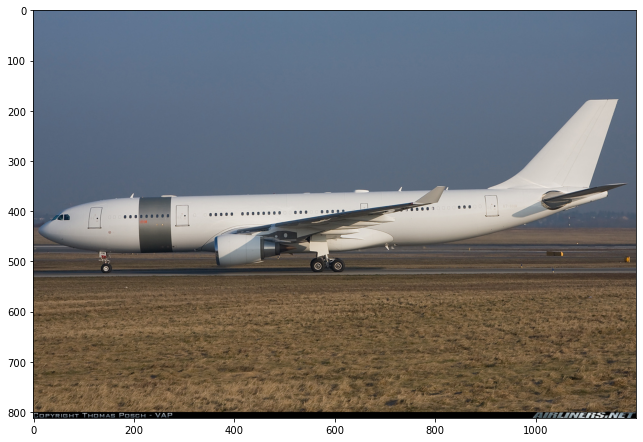

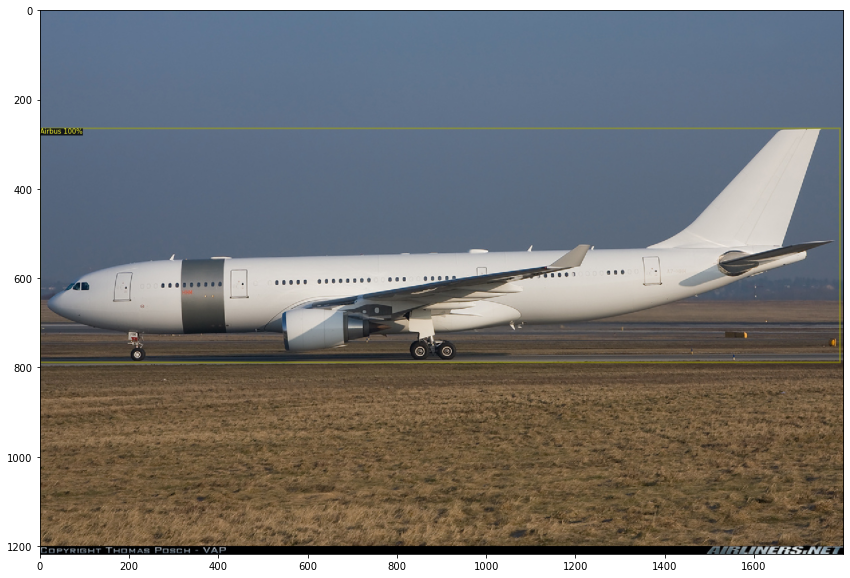

In [25]:
im = cv2.imread(test_image_file)
print(im.shape)
plt.figure(figsize=(15,7.5))
plt.imshow(im[..., ::-1])   

predictor = DefaultPredictor(cfg, model)

outputs = predictor(im[..., ::-1])
        
        
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(out.get_image()[..., ::-1][..., ::-1])

# Conclusion

#### Baseline Experiment
* Data: Converted to COCO
* Model: Resnet50 Faster-RCNN FPN, COCO Pretrained weights

|   AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:------:|:------:|:------:|:-----:|:-----:|:------:|
| 91.412 | 96.600 | 95.829 |  nan  |  nan  | 91.412 |

| category                 | AP     | category             | AP     | category             | AP     |
|:-------------------------|:-------|:---------------------|:-------|:---------------------|:-------|
| ATR                      | 96.341 | Airbus               | 93.161 | Antonov              | 94.794 |
| Beechcraft               | 92.867 | Boeing               | 94.067 | Bombardier Aerospace | 92.853 |
| British Aerospace        | 90.460 | Canadair             | 93.872 | Cessna               | 89.677 |
| Cirrus Aircraft          | 89.984 | Dassault Aviation    | 95.668 | Dornier              | 91.257 |
| Douglas Aircraft Company | 82.414 | Embraer              | 95.371 | Eurofighter          | 93.373 |
| Fairchild                | 92.097 | Fokker               | 93.718 | Gulfstream Aerospace | 91.910 |
| Ilyushin                 | 91.306 | Lockheed Corporation | 84.836 | Lockheed Martin      | 94.088 |
| McDonnell Douglas        | 87.587 | Panavia              | 94.274 | Piper                | 86.103 |
| Robin                    | 90.450 | Saab                 | 96.454 | Supermarine          | 77.434 |
| Tupolev                  | 94.180 | Yakovlev             | 92.042 | de Havilland         | 89.724 |

#### Class Balanced Experiment
* Data: Converted to COCO, Custom WeightedRandomSampler
* Model: Resnet50 Faster-RCNN FPN, COCO Pretrained weights

|   AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:------:|:------:|:------:|:-----:|:-----:|:------:|
| 89.569 | 95.452 | 94.815 |  nan  | 0.000 | 89.585 |

| category                 | AP     | category             | AP     | category             | AP     |
|:-------------------------|:-------|:---------------------|:-------|:---------------------|:-------|
| ATR                      | 94.710 | Airbus               | 92.614 | Antonov              | 92.915 |
| Beechcraft               | 94.096 | Boeing               | 92.298 | Bombardier Aerospace | 86.161 |
| British Aerospace        | 91.019 | Canadair             | 95.635 | Cessna               | 88.317 |
| Cirrus Aircraft          | 90.179 | Dassault Aviation    | 92.970 | Dornier              | 94.756 |
| Douglas Aircraft Company | 77.446 | Embraer              | 92.380 | Eurofighter          | 81.951 |
| Fairchild                | 90.522 | Fokker               | 88.231 | Gulfstream Aerospace | 91.321 |
| Ilyushin                 | 79.919 | Lockheed Corporation | 83.153 | Lockheed Martin      | 95.023 |
| McDonnell Douglas        | 86.652 | Panavia              | 94.099 | Piper                | 83.636 |
| Robin                    | 84.955 | Saab                 | 94.010 | Supermarine          | 81.291 |
| Tupolev                  | 97.046 | Yakovlev             | 92.281 | de Havilland         | 87.500 |

### Future Directions

Some obvious directions include obtaining more data to train on from publicly available datasets. Other more exotic 
things to try include:
1. Train for longer. There is likely some more performance we can squeeze out of the baseline, but there are likely significant
performance gains we can pull from the class balanced approach if we simply trained for longer. However, time and resources are
limited.
2. Leveraging a smarter loss function. Something like Reduced Focal Loss, which won the xView competition back in 2018
   (a notoriously long-tailed dataset), could help to overcome the class imbalance even better. That being said, this 
   would be more complex to implement as it would require modifying the Faster-RCNN FPN and Class head loss functions.
3. Performing downstream classifier fusion. It would be interesting to take the detected bounding boxes/labels and 
   construct a fusion approach (using logistic regression or something simple) that would ingest the output of WEFT 
   classifiers to help boost performance. The WEFT (Wings Engine Fuselage and Tail) classifiers would be downstream recognition
models that would attempt to ingest the detected object chip and classify sum attributes about the aircraft (e.g. number of engines, 
wingspan, engine type, etc.).